<a href="https://colab.research.google.com/github/johnzelson/nonprofits-colab/blob/main/S4_Geocode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview

This notebook geocodes (converts an address to latitude and longitude) local nonprofit location using the US Census api.   Geocoding enables mapping of the organizations.  

The Census api also returns codes that can be used later to explore demographic data and link to resources like Google Data Commons and Census Reporter.

Census api gives state and federal government districts, so elected representatives can be looked up via the US Congress api.



# Tech Notes


| In   | Description    |
|------- | --------------------- |
| np_cortland_df (local area)| Universe of Local Nonprofits to be analyzed |



| Out       | Description            |
|---------- | --------------------- |
| cort_geo  | Geocoded dataframe for area NPs |



# TODOS
- Since I'm slopping around dataframes and CSVs need to review dtypes for consistency. (eg various geocodes need to be integer or just string values)
- Add configurations, so the entire process can easily be rerun for different areas.

Notes:
Several nonprofits have PO Box addresses or college campus addresses which the Census geocoder doesn't locate.

PO Boxes dont' geocode, so I should do web search/scrape tools to identify address before geocoding.  In S5, the Bing web search api (free tier) is used to find websites, but it could be updated to get addresses.  



# Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.flush_and_unmount()

In [ ]:
import requests
import pprint
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import folium
from google.colab import userdata

pd.set_option('display.max_columns', 100);
pd.set_option('display.max_rows', 100);



In [ ]:
%pip install mapclassify

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 3.4 MB/s eta 0:00:00


# Use Census Geocode for each NP address

- Census provides batch and single address geocoding, up to 10k requests
- the batch method doesn't return all the census codes useful for future analysis, but single address does.
- Tried using Census Place names and subdvisions to match mailing address, but city names on post office weren't close enough match to census NLT lookup






## Load Cortland NPs DF(or area of interest)

In [ ]:
# Load the nonprofits that need geocoding
# NOTE: have a few cuts could try: cortland city, 10mi radius by zip, county by zip

#TODO: Ok, when to introduct np_local_df

dtype = {"EIN" : str,
         "ZIPCd" : str
         }

np_cortland_p_df = pd.read_csv('/content/drive/My Drive/IRS_processed/np_cortland_p_df.csv',
                           dtype=dtype)
display(np_cortland_p_df)



EIN                                        NAME  \
0    010939780          FREE & ACCEPTED MASONS OF NEW YORK   
1    030469943    DISABLED AMERICAN VETERANS AUXILIARY INC   
2    043658949                    SONS OF ITALY IN AMERICA   
3    115227037  CORTLANDVILLE FIRE DEPARTMENT INCORPORATED   
4    132951986   1890 HOUSE MUSEUM AND CENTER FOR THE ARTS   
..         ...                                         ...   
157  901504057                  TOASTMASTERS INTERNATIONAL   
158  920495583                     SEAHORSE FOUNDATION INC   
159  920791511          CENTRAL NEW YORK ACTION SPORTS INC   
160  922673272                       BARRY PRIMARY PTO INC   
161  990725348             AMERICAN FEDERATION OF TEACHERS   

                               ICO                STREET      CITY STATE  \
0               % JASON C TRABUCCO       15 EXCELSIOR ST  CORTLAND    NY   
1                % CAROL WHITMARSH  14813 STATE ROUTE 90  CORTLAND    NY   
2             % STEPHANIE DENSMORE            176 ELM ST  CORTLAND    NY   
3                              NaN      999 NYS ROUTE 13  CORTLAND    NY   
4                              NaN    37 TOMPKINS STREET  CORTLAND    NY   
..                             ...                   ...       ...   ...   
157              % THOMAS SORENSEN  3669 STATE ROUTE 281  CORTLAND    NY   
158              % RUSSELL PAULSEN     2112 KYPRIOTIS DR  CORTLAND    NY   
159             % TRAVIS MACDOWELL         2150 CLUTE RD  CORTLAND    NY   
160  % BARRY PRIMARY PTO TREASURER        20 RAYMOND AVE  CORTLAND    NY   
161                  % STEVEN NANN   781 STATE ROUTE 392  CORTLAND    NY   

            ZIP  GROUP  SUBSECTION  AFFILIATION  CLASSIFICATION  RULING  \
0    13045-2301    265          10            9            1000  194012   
1    13045-0000   2473           4            9            1000  197310   
2    13045-2322   3610           8            9            1000  194106   
3    13045-3548      0           3            3            1000  198602   
4    13045-0000      0           3            3            1000  197810   
..          ...    ...         ...          ...             ...     ...   
157  13045-8857    820           3            9            2000  194505   
158  13045-8503      0           3            3            1200  202307   
159  13045-0000      0           3            3            1000  202309   
160  13045-3322      0           3            3            1000  202305   
161  13045-9415    787           5            9            3000  196711   

     DEDUCTIBILITY  FOUNDATION   ACTIVITY  ORGANIZATION  STATUS  TAX_PERIOD  \
0                2           0  279036000             5       1    202312.0   
1                1           0  908921000             5       1    202306.0   
2                2           0          0             5       1    202312.0   
3                1          15  407994000             1       1    202212.0   
4                1          15   60000000             1       1    202212.0   
..             ...         ...        ...           ...     ...         ...   
157              1          16   59319000             1       1    202112.0   
158              1          15          0             1       1    202312.0   
159              1          16          0             1       1    202212.0   
160              1          15          0             1       1         NaN   
161              2           0  263264279             5       1         NaN   

     ASSET_CD  INCOME_CD  FILING_REQ_CD  PF_FILING_REQ_CD  ACCT_PD  ASSET_AMT  \
0           0          0              2                 0       12        0.0   
1           0          0              2                 0        6        0.0   
2           0          0              2                 0       12        0.0   
3           4          3              1                 0       12   220657.0   
4           4          3              1                 0       12   438205.0   
..        ...    

## Geocode

In [ ]:
# -------------------------------
#  iterate, geocode, each address  using census
# -------------------------------

# census allows 10k lookups (a day?)

# kick-off geocoding - uses defs:  geocode_address, collect_info

this_match = {}
not_match = {} # dict of NPs where census can't geocode.
#TODO: circle back to do websearch on these, get address, geocode

geo_list = []
not_match_list = []

#TODO: diff between itertuples

for index, row in np_cortland_p_df.iterrows():
  #TODO: use updated/corrected zipcode in row['zipcode']
  #print(row['STREET'], row['CITY'], row['STATE'], row['ZIP'])
  address = row['STREET'] + ', ' + row['CITY'] + ', ' + row['STATE'] + '  ' + row['ZIP']
  print ("\n--- Go get: ", address)

  data = geocode_address(address)
  num_matches = len(data['result']['addressMatches'])

  #pprint.pprint(data)
  # check data for no match, insert p_org_id and nulls
  if num_matches == 0:
    print (f"---> NO MATCH: {row['p_org_id']} {address}")
    not_match['p_org_id'] = row['p_org_id']
    not_match['address'] = address
    not_match_list.append(not_match)
    not_match = {}
    continue

  # save into list of dicts to create dataframe
  this_match = collect_info(data)
  this_match['p_org_id'] = row['p_org_id']
  this_match['num_matches'] = num_matches
  geo_list.append(this_match)

#TODO: consider name configurations to reflect which area being processed
cort_geo_df = pd.DataFrame.from_dict(geo_list)
not_match_df = pd.DataFrame.from_dict(not_match_list)




--- Go get:  15 EXCELSIOR ST, CORTLAND, NY  13045-2301
https://geocoding.geo.census.gov/geocoder/geographies/onelineaddress?address=15+EXCELSIOR+ST%2C+CORTLAND%2C+NY++13045-2301&benchmark=4&format=json&vintage=4&layers=all&key=c4dd4253d7612ea36d9b19e4ef12b5742268a4c3
sect 2020 Census Blocks
sect Counties
sect 118th Congressional Districts
sect County Subdivisions
sect Incorporated Places
sect Census Tracts
sect Combined Statistical Areas
sect 2022 State Legislative Districts - Upper
sect 2022 State Legislative Districts - Lower
collected fields:

--- Go get:  14813 STATE ROUTE 90, CORTLAND, NY  13045-0000
https://geocoding.geo.census.gov/geocoder/geographies/onelineaddress?address=14813+STATE+ROUTE+90%2C+CORTLAND%2C+NY++13045-0000&benchmark=4&format=json&vintage=4&layers=all&key=c4dd4253d7612ea36d9b19e4ef12b5742268a4c3
sect 2020 Census Blocks
sect Counties
sect 118th Congressional Districts
sect County Subdivisions
sect Incorporated Places
sect Census Tracts
sect Combined Statistical 

In [ ]:
def collect_info(data):
  """
  Extracts desired into from returned geocode json for append to DF

  Parameters:
    data(json): Census Geocode info

  Returns:
    this_match (dict): consistently named data to append to DF

  """


  this_match = {}
  geo_sects_names = {}

  section = data['result']['addressMatches'][0]['coordinates']
  sect_name = 'coord_'
  selected = ['x', 'y']
  for fld in selected:
    this_match[sect_name + fld] = section[fld]

  # TODO: put this in __main__ or create class to avoid repeating
  # dict of sections to get to section abbrev for keys
  geo_sects_names = {'2020 Census Blocks': 'cb_',
                    'Counties' : 'cnty_',
                    '118th Congressional Districts' : 'cong_',
                    'County Subdivisions' : 'cntysub_',
                    'Incorporated Places' : 'inc_',
                    'Census Tracts' : 'centracts_',
                    'Combined Statistical Areas' : 'csa_',
                    '2022 State Legislative Districts - Upper' : 'legup_',
                    '2022 State Legislative Districts - Lower' : 'leglow_'
                    }
  geo_sects_flds = {'2020 Census Blocks': ['BASENAME', 'BLKGRP', 'BLOCK', 'GEOID', 'NAME', 'TRACT', 'COUNTY', 'STATE'],
                    'Counties' : ['COUNTY', 'NAME', 'STATE', 'COUNTY', 'STATE'],
                    '118th Congressional Districts' : ['BASENAME', 'NAME'],
                    'County Subdivisions' : ['NAME', 'COUSUB', 'GEOID'],
                    'Incorporated Places' : ['PLACE'],
                    'Census Tracts' : ['NAME', 'TRACT'],
                    'Combined Statistical Areas' : ['NAME', 'GEOID'],
                    '2022 State Legislative Districts - Upper' : ['NAME'],
                    '2022 State Legislative Districts - Lower' : ['NAME']
                  }


  for sect in geo_sects_names:
    print ("sect" , sect)
    if sect in data['result']['addressMatches'][0]['geographies']:
      section = data['result']['addressMatches'][0]['geographies'][sect][0]
      sect_name = geo_sects_names[sect]
      # print ("sect name: ", sect_name)
      for fld in geo_sects_flds[sect]:
        this_match[sect_name + fld] = section[fld]
    else:
      for fld in geo_sects_flds[sect]:
        this_match[sect_name + fld] = 'na'

  #print ("collected fields:")
  #for i in this_match:
  #  print (f"\t {i} :  {this_match[i]}")

  return this_match




In [ ]:
def geocode_address(address):

# the batch geocoding from BMF doesn't get place fips
# Note: tried to match to postal cities to Census names (NLT),
# but doesn't match
# looking up each nonprofit provides the key data for future analysis

  base_url = "https://geocoding.geo.census.gov/geocoder/geographies/onelineaddress"

  # Set up the parameters for the API request
  params = {
      'address': address,
      #'benchmark': 'Public_AR_Current',  # Use the current benchmark
      'benchmark': '4',
      'format': 'json',
      'vintage': '4',
      'layers': 'all',
      'key': ckey
  }

  # Send a GET request to the API
  response = requests.get(base_url, params=params)

  print(response.url)

  #TODO: handle errors
  # Check if the response was successful
  if response.status_code == 200:
    data = response.json()
    return (data)
  else:
      return f"Error: {response.status_code}"


# Add Elected Reps

with geocoded addresses, can get links for elected reps
who represent the nonprofit.



In [ ]:
# ---- load congressional district members for lookups ---

#TODO: could look up dynamically, as info will become obsolete.  Modular approach,
# these steps, should be designed to rerun just this section, too.

# assumes cort_geo_df

import requests
import pprint

# list of dicts for house member for each district in dataset
cong_mbr_dict = {}  # save each from def
district_dict = {}  # save all with text of data label as key for easy lookup


base_url = 'https://api.congress.gov/v3/member/congress'
#TODO:get current congress...
# for now, assume current congress and NY
cong_nbr = '118'  # current congress 118th
state = 'NY'

from google.colab import userdata
cong_key = userdata.get('congress')

# house of representatives
district_nbrs = cort_geo_df['cong_BASENAME'].unique()

for dist in district_nbrs:
  if not pd.isnull(dist):
    #this_dist_list = dist.split(' ')
    #this_dist = this_dist_list[-1]
    dist = str(int(dist))
    cong_mbr_dict = get_congress_members(cong_nbr, state, dist)

    district_dict[dist] = cong_mbr_dict

pprint.pprint (district_dict)


https://api.congress.gov/v3/member/congress/118/NY/19
https://api.congress.gov/v3/member/congress/118/NY/24
{'19': {'bioguideId': 'M001221',
        'house_url': 'https://clerk.house.gov/members/M001221',
        'name': 'Molinaro, Marcus J.',
        'partyName': 'Republican'},
 '24': {'bioguideId': 'T000478',
        'house_url': 'https://clerk.house.gov/members/T000478',
        'name': 'Tenney, Claudia',
        'partyName': 'Republican'}}


In [ ]:
# congress api: load unique congressional districts for lookup

def get_congress_members(cong_nbr, state, dist):
# https://api.congress.gov/v3/member/118/NY/19?api_key=pYKHRuu4IQNyahFhDLEeiCGJhCILctRhjY6QdYVA
# https://api.congress.gov/v3/member/congress/118/MI/10?api_key=[INSERT_KEY]
# one way of linking  https://clerk.house.gov/members/M001221

  #TODO: feels wierd to not pass base_url to def. Notebook scope review.
  this_mbr_dict = {}
  url = f"{base_url}/{cong_nbr}/{state}/{dist}"
  print (url)

  params = {"api_key": cong_key, "format" : "json"}
  response = requests.get(url, params=params)
  # response.raise_for_status() # should add actual check
  search_results = response.json()
  # print (response.text)

  # save whatever seems useful for display
  this_mbr_dict['bioguideId'] = search_results['members'][0]['bioguideId']
  this_mbr_dict['name'] = search_results['members'][0]['name']
  this_mbr_dict['partyName'] = search_results['members'][0]['partyName']
  this_mbr_dict['house_url'] = 'https://clerk.house.gov/members/'
  this_mbr_dict['house_url'] += search_results['members'][0]['bioguideId']


  return this_mbr_dict




## Add elected reps to geo dataframe

### House of Representatives

In [ ]:
# with district_dict populated, add column to cort_geo_df

def add_congress_link(dist_nbr):
  dist_nbr = str(int(dist_nbr))
  p = "(" + district_dict[dist_nbr]["partyName"][0] + ")"
  link = "<a href=\"" + district_dict[dist_nbr]["house_url"] + "\" target=\"_blank\">"
  link +=f"{district_dict[dist_nbr]['name']} {p} &#8594; </a>"
  return link

cort_geo_df['congress_rep_link'] = cort_geo_df['cong_BASENAME'].apply(add_congress_link)

display(cort_geo_df)


coord_x    coord_y  cb_BASENAME  cb_BLKGRP  cb_BLOCK         cb_GEOID  \
0   -76.165818  42.602655         1012          1      1012  360239705001012   
1   -76.269550  42.640647         2036          2      2036  360110409002036   
2   -76.161390  42.602587         1008          1      1008  360239705001008   
3   -76.213478  42.577320         4021          4      4021  360239710004021   
4   -76.182607  42.596112         3001          3      3001  360239709003001   
..         ...        ...          ...        ...       ...              ...   
119 -76.212392  42.584088         5003          5      5003  360239710005003   
120 -76.136368  42.510204         1032          1      1032  360239712001032   
121 -76.146317  42.512639         2075          2      2075  360239712002075   
122 -76.190993  42.587718         4012          4      4012  360239709004012   
123 -76.223742  42.494106         4013          4      4013  360239712004013   

        cb_NAME  cb_TRACT  cb_COUNTY  cb_STATE  cnty_COUNTY        cnty_NAME  \
0    Block 1012    970500         23        36           23  Cortland County   
1    Block 2036     40900         11        36           11    Cayuga County   
2    Block 1008    970500         23        36           23  Cortland County   
3    Block 4021    971000         23        36           23  Cortland County   
4    Block 3001    970900         23        36           23  Cortland County   
..          ...       ...        ...       ...          ...              ...   
119  Block 5003    971000         23        36           23  Cortland County   
120  Block 1032    971200         23        36           23  Cortland County   
121  Block 2075    971200         23        36           23  Cortland County   
122  Block 4012    970900         23        36           23  Cortland County   
123  Block 4013    971200         23        36           23  Cortland County   

     cnty_STATE  cong_BASENAME                  cong_NAME        cntysub_NAME  \
0            36             19  Congressional District 19       Cortland city   
1            36             24  Congressional District 24     Summerhill town   
2            36             19  Congressional District 19       Cortland city   
3            36             19  Congressional District 19  Cortlandville town   
4            36             19  Congressional District 19       Cortland city   
..          ...            ...                        ...                 ...   
119          36             19  Congressional District 19  Cortlandville town   
120          36             19  Congressional District 19         Virgil town   
121          36             19  Congressional District 19         Virgil town   
122          36             19  Congressional District 19       Cortland city   
123          36             19  Congressional District 19         Virgil town   

     cntysub_COUSUB  cntysub_GEOID  inc_PLACE     centracts_NAME  \
0             18388     3602318388    18388.0  Census Tract 9705   
1             72037     3601172037        NaN   Census Tract 409   
2             18388     3602318388    18388.0  Census Tract 9705   
3             18421     3602318421        NaN  Census Tract 9710   
4             18388     3602318388    18388.0  Census Tract 9709   
..              ...            ...        ...                ...   
119           18421     3602318421        NaN  Census Tract 9710   
120           77596     3602377596        NaN  Census Tract 9712   
121           77596     3602377596        NaN  Census Tract 9712   
122           18388     3602318388    18388.0  Census Tract 9709   
123           77596     3602377596        NaN  Census Tract 9712   

     centracts_TRACT                 csa_NAME  csa_GEOID  \
0             970500  Ithaca-Cortland, NY CSA        296   
1              40900  Syracuse-Auburn, NY CSA        532   
2             970500  Ithaca-Cortland, NY CSA        296   
3             971000  Ithaca-Cortland, NY CSA        29

In [ ]:
# quick data checks
#quick = cort_geo_df['Congress_Rep_Link'].to_list()
#quick = cort_geo_df['state_leg_low_link'].to_list()
quick = cort_geo_df['state_leg_upper_link'].to_list()

##
print (quick)


['<a href="https://www.nysenate.gov/district/52" target="_blank"> State Senate District 52 &#8594;</a>', '<a href="https://www.nysenate.gov/district/48" target="_blank"> State Senate District 48 &#8594;</a>', '<a href="https://www.nysenate.gov/district/52" target="_blank"> State Senate District 52 &#8594;</a>', '<a href="https://www.nysenate.gov/district/52" target="_blank"> State Senate District 52 &#8594;</a>', '<a href="https://www.nysenate.gov/district/52" target="_blank"> State Senate District 52 &#8594;</a>', '<a href="https://www.nysenate.gov/district/52" target="_blank"> State Senate District 52 &#8594;</a>', '<a href="https://www.nysenate.gov/district/52" target="_blank"> State Senate District 52 &#8594;</a>', '<a href="https://www.nysenate.gov/district/52" target="_blank"> State Senate District 52 &#8594;</a>', '<a href="https://www.nysenate.gov/district/52" target="_blank"> State Senate District 52 &#8594;</a>', '<a href="https://www.nysenate.gov/district/52" target="_blank"

### State Upper (State Senate) and Lower (State Assembly)

In [ ]:
def leg_upper(leg_upper_name):
  """ Extract legislative info number and build url

  Note:
  Census geocode returns text, hopefully dependable, where
  last part of name can be used to build external link

  """
  #TODO: Research how to get the number instead of extracting

  base_url = 'https://www.nysenate.gov/district'
  legup_parts = leg_upper_name.split(' ')

  #https://www.nysenate.gov/district/48
  legup_link = (f"<a href=\"https://www.nysenate.gov/district/{legup_parts[-1]}\" "
                f"target=\"_blank\"> {leg_upper_name} &#8594;</a>")
  return legup_link


def leg_lower(leg_lower_name):
  base_url = 'https://www.assembly.state.ny.us/mem/'
  leglow_parts = leg_lower_name.split(' ')

  leglow_link = (f"<a href=\"https://www.assembly.state.ny.us/mem/?ad={leglow_parts[-1]}&sh=about\" "
                f"target=\"_blank\">{leg_lower_name} &#8594;</a>")

  return leglow_link

cort_geo_df['state_leg_lower_link'] = cort_geo_df['leglow_NAME'].apply(leg_lower)
cort_geo_df['state_leg_upper_link'] = cort_geo_df['legup_NAME'].apply(leg_upper)


display(cort_geo_df)



coord_x    coord_y  cb_BASENAME  cb_BLKGRP  cb_BLOCK         cb_GEOID  \
0   -76.165818  42.602655         1012          1      1012  360239705001012   
1   -76.269550  42.640647         2036          2      2036  360110409002036   
2   -76.161390  42.602587         1008          1      1008  360239705001008   
3   -76.213478  42.577320         4021          4      4021  360239710004021   
4   -76.182607  42.596112         3001          3      3001  360239709003001   
..         ...        ...          ...        ...       ...              ...   
119 -76.212392  42.584088         5003          5      5003  360239710005003   
120 -76.136368  42.510204         1032          1      1032  360239712001032   
121 -76.146317  42.512639         2075          2      2075  360239712002075   
122 -76.190993  42.587718         4012          4      4012  360239709004012   
123 -76.223742  42.494106         4013          4      4013  360239712004013   

        cb_NAME  cb_TRACT  cb_COUNTY  cb_STATE  cnty_COUNTY        cnty_NAME  \
0    Block 1012    970500         23        36           23  Cortland County   
1    Block 2036     40900         11        36           11    Cayuga County   
2    Block 1008    970500         23        36           23  Cortland County   
3    Block 4021    971000         23        36           23  Cortland County   
4    Block 3001    970900         23        36           23  Cortland County   
..          ...       ...        ...       ...          ...              ...   
119  Block 5003    971000         23        36           23  Cortland County   
120  Block 1032    971200         23        36           23  Cortland County   
121  Block 2075    971200         23        36           23  Cortland County   
122  Block 4012    970900         23        36           23  Cortland County   
123  Block 4013    971200         23        36           23  Cortland County   

     cnty_STATE  cong_BASENAME                  cong_NAME        cntysub_NAME  \
0            36             19  Congressional District 19       Cortland city   
1            36             24  Congressional District 24     Summerhill town   
2            36             19  Congressional District 19       Cortland city   
3            36             19  Congressional District 19  Cortlandville town   
4            36             19  Congressional District 19       Cortland city   
..          ...            ...                        ...                 ...   
119          36             19  Congressional District 19  Cortlandville town   
120          36             19  Congressional District 19         Virgil town   
121          36             19  Congressional District 19         Virgil town   
122          36             19  Congressional District 19       Cortland city   
123          36             19  Congressional District 19         Virgil town   

     cntysub_COUSUB  cntysub_GEOID  inc_PLACE     centracts_NAME  \
0             18388     3602318388    18388.0  Census Tract 9705   
1             72037     3601172037        NaN   Census Tract 409   
2             18388     3602318388    18388.0  Census Tract 9705   
3             18421     3602318421        NaN  Census Tract 9710   
4             18388     3602318388    18388.0  Census Tract 9709   
..              ...            ...        ...                ...   
119           18421     3602318421        NaN  Census Tract 9710   
120           77596     3602377596        NaN  Census Tract 9712   
121           77596     3602377596        NaN  Census Tract 9712   
122           18388     3602318388    18388.0  Census Tract 9709   
123           77596     3602377596        NaN  Census Tract 9712   

     centracts_TRACT                 csa_NAME  csa_GEOID  \
0             970500  Ithaca-Cortland, NY CSA        296   
1              40900  Syracuse-Auburn, NY CSA        532   
2             970500  Ithaca-Cortland, NY CSA        296   
3             971000  Ithaca-Cortland, NY CSA        29

## Save geo file with elected reps

## Save Match, cort_geo_df here, and Not Match DFs into csv

In [ ]:
cort_geo_df


#TODO: for unmatched (po boxes) use web search

NameError: name 'cort_geo_df' is not defined

# Get population from Google Commons

# Colocation?

In [ ]:
# read, if necessary

cort_geo_df = pd.read_csv('/content/drive/My Drive/IRS_processed/cortland_geo_df.csv')
display(cort_geo_df)

cort_geo_df['cntysub_COUSUB'].isna().sum()  #0
cort_geo_df['cntysub_GEOID'].isna().sum()  #0




0

In [ ]:
# save incremental processing


cort_geo_df.to_csv('/content/drive/My Drive/IRS_processed/cortland_geo_df.csv',
                   index=False)

#TODO: for unmatched (po boxes) use web search
not_match_df.to_csv('/content/drive/My Drive/IRS_processed/cortland_not_match_df.csv',
                    index=False)

# Mapping-related tests

These cells are related to testing geocode data on maps.  Probably should be moved to a different notebook, maybe a seperate one...

Most of the data used has been pre-processed, so just load the csv/panda dataframes.
Merge each set of info into a single dataframe for plots,  analysis, streamlit app

## Load processed tax returns (latest for each ein)

In [ ]:
# obsolete - not merging till step 5...

# --------------------------------------
# Load processed tax returns
# ---------------------------------------

#TODO: use proc_dir configuration in def or setup cell
proc_dir = '/content/drive/My Drive/irs_processed/'

dtype = {"EIN" : str,
         "ZIPCd" : str
         }

IRS_latest_df = pd.read_csv('/content/drive/My Drive/IRS_processed/irs_latest_df.csv', dtype=dtype)

display(IRS_latest_df)

## Load cortland, geocode info, and tracts

Tract shapefile not needed until mapping

In [ ]:
#  --- Load Geocoded addresses ----
# geocode of cortland addresses with a bunch of codes/info from census
# not used unless backtracking through process
# all been combined into cortland_geotaxweb
cort_geo_df = pd.read_csv('/content/drive/My Drive/IRS_processed/cortland_geo_df.csv')
display(cort_geo_df)


coord_x    coord_y  cb_BASENAME  cb_BLKGRP  cb_BLOCK         cb_GEOID  \
0   -76.165818  42.602655         1012          1      1012  360239705001012   
1   -76.269550  42.640647         2036          2      2036  360110409002036   
2   -76.161390  42.602587         1008          1      1008  360239705001008   
3   -76.213478  42.577320         4021          4      4021  360239710004021   
4   -76.182607  42.596112         3001          3      3001  360239709003001   
..         ...        ...          ...        ...       ...              ...   
119 -76.212392  42.584088         5003          5      5003  360239710005003   
120 -76.136368  42.510204         1032          1      1032  360239712001032   
121 -76.146317  42.512639         2075          2      2075  360239712002075   
122 -76.190993  42.587718         4012          4      4012  360239709004012   
123 -76.223742  42.494106         4013          4      4013  360239712004013   

        cb_NAME  cb_TRACT  cb_COUNTY  cb_STATE  cnty_COUNTY        cnty_NAME  \
0    Block 1012    970500         23        36           23  Cortland County   
1    Block 2036     40900         11        36           11    Cayuga County   
2    Block 1008    970500         23        36           23  Cortland County   
3    Block 4021    971000         23        36           23  Cortland County   
4    Block 3001    970900         23        36           23  Cortland County   
..          ...       ...        ...       ...          ...              ...   
119  Block 5003    971000         23        36           23  Cortland County   
120  Block 1032    971200         23        36           23  Cortland County   
121  Block 2075    971200         23        36           23  Cortland County   
122  Block 4012    970900         23        36           23  Cortland County   
123  Block 4013    971200         23        36           23  Cortland County   

     cnty_STATE  cong_BASENAME                  cong_NAME        cntysub_NAME  \
0            36             19  Congressional District 19       Cortland city   
1            36             24  Congressional District 24     Summerhill town   
2            36             19  Congressional District 19       Cortland city   
3            36             19  Congressional District 19  Cortlandville town   
4            36             19  Congressional District 19       Cortland city   
..          ...            ...                        ...                 ...   
119          36             19  Congressional District 19  Cortlandville town   
120          36             19  Congressional District 19         Virgil town   
121          36             19  Congressional District 19         Virgil town   
122          36             19  Congressional District 19       Cortland city   
123          36             19  Congressional District 19         Virgil town   

     cntysub_COUSUB  cntysub_GEOID  inc_PLACE     centracts_NAME  \
0             18388     3602318388    18388.0  Census Tract 9705   
1             72037     3601172037        NaN   Census Tract 409   
2             18388     3602318388    18388.0  Census Tract 9705   
3             18421     3602318421        NaN  Census Tract 9710   
4             18388     3602318388    18388.0  Census Tract 9709   
..              ...            ...        ...                ...   
119           18421     3602318421        NaN  Census Tract 9710   
120           77596     3602377596        NaN  Census Tract 9712   
121           77596     3602377596        NaN  Census Tract 9712   
122           18388     3602318388    18388.0  Census Tract 9709   
123           77596     3602377596        NaN  Census Tract 9712   

     centracts_TRACT                 csa_NAME  csa_GEOID  \
0             970500  Ithaca-Cortland, NY CSA        296   
1              40900  Syracuse-Auburn, NY CSA        532   
2             970500  Ithaca-Cortland, NY CSA        296   
3             971000  Ithaca-Cortland, NY CSA        29

# load tracts?

In [ ]:
# --- load shape file for tracts in new york ----
# NOTE:  census api gets a zip file and gpd seems to handle files
# instead of hitting api every test, put other files (shx, prj, etc, into same folder works

tracts_gpd = gpd.read_file('/content/drive/My Drive/IRS_processed/tl_2022_36_tract.shp')

# gdf_1 = gpd.GeoDataFrame(df1, geometry=geometry, crs='EPSG:4326')

# only need cortland county
tracts_cc_gpd = tracts_gpd[tracts_gpd['COUNTYFP'] == '023']

display(tracts_cc_gpd)



STATEFP COUNTYFP TRACTCE        GEOID     NAME              NAMELSAD  \
752       36      023  970600  36023970600     9706     Census Tract 9706   
753       36      023  970700  36023970700     9707     Census Tract 9707   
754       36      023  970800  36023970800     9708     Census Tract 9708   
755       36      023  970900  36023970900     9709     Census Tract 9709   
756       36      023  971000  36023971000     9710     Census Tract 9710   
757       36      023  971100  36023971100     9711     Census Tract 9711   
2072      36      023  970300  36023970300     9703     Census Tract 9703   
3196      36      023  970202  36023970202  9702.02  Census Tract 9702.02   
3197      36      023  970201  36023970201  9702.01  Census Tract 9702.01   
4480      36      023  970500  36023970500     9705     Census Tract 9705   
4506      36      023  970400  36023970400     9704     Census Tract 9704   
4745      36      023  970100  36023970100     9701     Census Tract 9701   
5163      36      023  971200  36023971200     9712     Census Tract 9712   

      MTFCC FUNCSTAT      ALAND   AWATER     INTPTLAT      INTPTLON  \
752   G5020        S    1331961        0  +42.5993688  -076.1735548   
753   G5020        S    2082176        0  +42.6048946  -076.1921961   
754   G5020        S     669282        0  +42.5950915  -076.1936695   
755   G5020        S    3080667        0  +42.5916962  -076.1756057   
756   G5020        S   50868308   185522  +42.5983802  -076.2345901   
757   G5020        S  262915283  1878767  +42.4913444  -075.9623665   
2072  G5020        S    3470035     3620  +42.6392745  -076.1856950   
3196  G5020        S  126600748  1187968  +42.6620495  -076.1701665   
3197  G5020        S  127136478  2229049  +42.7245025  -076.1663193   
4480  G5020        S    2921290    51890  +42.6077228  -076.1717008   
4506  G5020        S   77913085   274001  +42.5870167  -076.1131464   
4745  G5020        S  382730819   799861  +42.6719950  -075.9842258   
5163  G5020        S  250097821   499960  +42.4779417  -076.1628829   

                                               geometry  
752   POLYGON ((-76.18069 42.60544, -76.17957 42.605...  
753   POLYGON ((-76.20049 42.61248, -76.19596 42.612...  
754   POLYGON ((-76.19917 42.59558, -76.199 42.59565...  
755   POLYGON ((-76.19862 42.58856, -76.19758 42.588...  
756   POLYGON ((-76.26561 42.62542, -76.26561 42.625...  
757   POLYGON ((-76.08391 42.54237, -76.07777 42.542...  
2072  POLYGON ((-76.19525 42.63942, -76.19302 42.639...  
3196  POLYGON ((-76.27001 42.69833, -76.2694 42.6983...  
3197  POLYGON ((-76.27467 42.77126, -76.26814 42.771...  
4480  POLYGON ((-76.18641 42.61306, -76.1864 42.6131...  
4506  POLYGON ((-76.19321 42.5671, -76.19319 42.5691...  
4745  POLYGON ((-76.08018 42.78043, -76.08017 42.781...  
5163  POLYGON ((-76.26148 42.55045, -76.25404 42.550...

In [ ]:
display(cortland_df)
# tracts_gpd.info()
# tracts_gpd.shape

In [ ]:
print ("cortland df: ", type(cortland_df))
print ("cort_geo_df: ", type(cort_geo_df))
print ("tracts_gpd: ", type(tracts_gpd))


## Get Census Tracts

In [ ]:
#TODO: Get some census data and merge into tract dataframe for map

# ---- Use Census API directly to get tract shapefile ---
# note:  api only used once, as it's saved to folder and read from folder
#TODO:  move to plotting section

year = '2022'
state = '36'
county = '023'

# read in tract data
df_tract = gpd.read_file(f"https://www2.census.gov/geo/tiger/TIGER{year}/TRACT/tl_{year}_{state}_tract.zip")
print("Num of rows:", len(df_tract))
print("Num of columns:", len(df_tract.columns))
#df_tract['geo_id'] = df_tract.apply(lambda x: 'GEOID ' + x['GEOID'], axis=1)
#df_tract = df_tract[['geo_id', 'geometry']]
df_tract.head(1)



Num of rows: 5411
Num of columns: 13


STATEFP COUNTYFP TRACTCE        GEOID    NAME             NAMELSAD  MTFCC  \
0      36      007  012702  36007012702  127.02  Census Tract 127.02  G5020   

  FUNCSTAT     ALAND  AWATER     INTPTLAT      INTPTLON  \
0        S  65461841  222705  +42.0350532  -075.9055509   

                                            geometry  
0  POLYGON ((-75.95917 42.00852, -75.95914 42.008...

# Merge cortland NPs to geocoding and latest tax info

TODO:obsolete, yes? moved to step 5

In [ ]:
# merge cortland_df with cort_geo_df by p_org_id

np_cortland_p_df = cortland_df.merge(cort_geo_df, on='p_org_id', how='left')
display(np_cortland_p_df)

cortland_df = cortland_df.merge(cort_geo_df, on='p_org_id', how='left')
display(cortland_df)

#TODO: convert tract, geoid to int
#TODO: save updated cortland_df as csv


EIN                                        NAME  \
0     10939780          FREE & ACCEPTED MASONS OF NEW YORK   
1     30469943    DISABLED AMERICAN VETERANS AUXILIARY INC   
2     43658949                    SONS OF ITALY IN AMERICA   
3    115227037  CORTLANDVILLE FIRE DEPARTMENT INCORPORATED   
4    132951986   1890 HOUSE MUSEUM AND CENTER FOR THE ARTS   
..         ...                                         ...   
157  901504057                  TOASTMASTERS INTERNATIONAL   
158  920495583                     SEAHORSE FOUNDATION INC   
159  920791511          CENTRAL NEW YORK ACTION SPORTS INC   
160  922673272                       BARRY PRIMARY PTO INC   
161  990725348             AMERICAN FEDERATION OF TEACHERS   

                               ICO                STREET      CITY STATE  \
0               % JASON C TRABUCCO       15 EXCELSIOR ST  CORTLAND    NY   
1                % CAROL WHITMARSH  14813 STATE ROUTE 90  CORTLAND    NY   
2             % STEPHANIE DENSMORE            176 ELM ST  CORTLAND    NY   
3                              NaN      999 NYS ROUTE 13  CORTLAND    NY   
4                              NaN    37 TOMPKINS STREET  CORTLAND    NY   
..                             ...                   ...       ...   ...   
157              % THOMAS SORENSEN  3669 STATE ROUTE 281  CORTLAND    NY   
158              % RUSSELL PAULSEN     2112 KYPRIOTIS DR  CORTLAND    NY   
159             % TRAVIS MACDOWELL         2150 CLUTE RD  CORTLAND    NY   
160  % BARRY PRIMARY PTO TREASURER        20 RAYMOND AVE  CORTLAND    NY   
161                  % STEVEN NANN   781 STATE ROUTE 392  CORTLAND    NY   

            ZIP  GROUP  SUBSECTION  AFFILIATION  CLASSIFICATION  RULING  \
0    13045-2301    265          10            9            1000  194012   
1    13045-0000   2473           4            9            1000  197310   
2    13045-2322   3610           8            9            1000  194106   
3    13045-3548      0           3            3            1000  198602   
4    13045-0000      0           3            3            1000  197810   
..          ...    ...         ...          ...             ...     ...   
157  13045-8857    820           3            9            2000  194505   
158  13045-8503      0           3            3            1200  202307   
159  13045-0000      0           3            3            1000  202309   
160  13045-3322      0           3            3            1000  202305   
161  13045-9415    787           5            9            3000  196711   

     DEDUCTIBILITY  FOUNDATION   ACTIVITY  ORGANIZATION  STATUS  TAX_PERIOD  \
0                2           0  279036000             5       1    202312.0   
1                1           0  908921000             5       1    202306.0   
2                2           0          0             5       1    202312.0   
3                1          15  407994000             1       1    202212.0   
4                1          15   60000000             1       1    202212.0   
..             ...         ...        ...           ...     ...         ...   
157              1          16   59319000             1       1    202112.0   
158              1          15          0             1       1    202312.0   
159              1          16          0             1       1    202212.0   
160              1          15          0             1       1         NaN   
161              2           0  263264279             5       1         NaN   

     ASSET_CD  INCOME_CD  FILING_REQ_CD  PF_FILING_REQ_CD  ACCT_PD  ASSET_AMT  \
0           0          0              2                 0       12        0.0   
1           0          0              2                 0        6        0.0   
2           0          0              2                 0       12        0.0   
3           4          3              1                 0       12   220657.0   
4           4          3              1                 0       12   438205.0   
..        ...    

In [ ]:
# merge cortland NPs with tax returns
# TODO: EIN is a int64, should be an object.


np_cortland_p_df = np_cortland_p_df.merge(IRS_latest_df, on='EIN', how='left')
display(np_cortland_p_df)



cortland_df = cortland_df.merge(IRS_latest_df, on='EIN', how='left')
display(cortland_df)
# 162


EIN                                        NAME  \
0     10939780          FREE & ACCEPTED MASONS OF NEW YORK   
1     30469943    DISABLED AMERICAN VETERANS AUXILIARY INC   
2     43658949                    SONS OF ITALY IN AMERICA   
3    115227037  CORTLANDVILLE FIRE DEPARTMENT INCORPORATED   
4    132951986   1890 HOUSE MUSEUM AND CENTER FOR THE ARTS   
..         ...                                         ...   
157  901504057                  TOASTMASTERS INTERNATIONAL   
158  920495583                     SEAHORSE FOUNDATION INC   
159  920791511          CENTRAL NEW YORK ACTION SPORTS INC   
160  922673272                       BARRY PRIMARY PTO INC   
161  990725348             AMERICAN FEDERATION OF TEACHERS   

                               ICO                STREET      CITY STATE  \
0               % JASON C TRABUCCO       15 EXCELSIOR ST  CORTLAND    NY   
1                % CAROL WHITMARSH  14813 STATE ROUTE 90  CORTLAND    NY   
2             % STEPHANIE DENSMORE            176 ELM ST  CORTLAND    NY   
3                              NaN      999 NYS ROUTE 13  CORTLAND    NY   
4                              NaN    37 TOMPKINS STREET  CORTLAND    NY   
..                             ...                   ...       ...   ...   
157              % THOMAS SORENSEN  3669 STATE ROUTE 281  CORTLAND    NY   
158              % RUSSELL PAULSEN     2112 KYPRIOTIS DR  CORTLAND    NY   
159             % TRAVIS MACDOWELL         2150 CLUTE RD  CORTLAND    NY   
160  % BARRY PRIMARY PTO TREASURER        20 RAYMOND AVE  CORTLAND    NY   
161                  % STEVEN NANN   781 STATE ROUTE 392  CORTLAND    NY   

            ZIP  GROUP  SUBSECTION  AFFILIATION  CLASSIFICATION  RULING  \
0    13045-2301    265          10            9            1000  194012   
1    13045-0000   2473           4            9            1000  197310   
2    13045-2322   3610           8            9            1000  194106   
3    13045-3548      0           3            3            1000  198602   
4    13045-0000      0           3            3            1000  197810   
..          ...    ...         ...          ...             ...     ...   
157  13045-8857    820           3            9            2000  194505   
158  13045-8503      0           3            3            1200  202307   
159  13045-0000      0           3            3            1000  202309   
160  13045-3322      0           3            3            1000  202305   
161  13045-9415    787           5            9            3000  196711   

     DEDUCTIBILITY  FOUNDATION   ACTIVITY  ORGANIZATION  STATUS  TAX_PERIOD  \
0                2           0  279036000             5       1    202312.0   
1                1           0  908921000             5       1    202306.0   
2                2           0          0             5       1    202312.0   
3                1          15  407994000             1       1    202212.0   
4                1          15   60000000             1       1    202212.0   
..             ...         ...        ...           ...     ...         ...   
157              1          16   59319000             1       1    202112.0   
158              1          15          0             1       1    202312.0   
159              1          16          0             1       1    202212.0   
160              1          15          0             1       1         NaN   
161              2           0  263264279             5       1         NaN   

     ASSET_CD  INCOME_CD  FILING_REQ_CD  PF_FILING_REQ_CD  ACCT_PD  ASSET_AMT  \
0           0          0              2                 0       12        0.0   
1           0          0              2                 0        6        0.0   
2           0          0              2                 0       12        0.0   
3           4          3              1                 0       12   220657.0   
4           4          3              1                 0       12   438205.0   
..        ...    

In [ ]:
# save updated cortland_df with after the merges

cortland_df.to_csv('/content/drive/My Drive/IRS_geocode/cortland_df_with_tax.csv')


NameError: name 'cortland_df' is not defined

In [ ]:
#cortland_df.info()
#IRS_latest_df.info()

# quick tests

# list(cortland_geotaxweb_df['p_org_id'])
cortland_geotaxweb_df[['p_org_id','NAME']]
#df[['Name', 'Qualification']]


p_org_id                                        NAME
0         449          FREE & ACCEPTED MASONS OF NEW YORK
1         949    DISABLED AMERICAN VETERANS AUXILIARY INC
2        1285                    SONS OF ITALY IN AMERICA
3       14649  CORTLANDVILLE FIRE DEPARTMENT INCORPORATED
4       18383   1890 HOUSE MUSEUM AND CENTER FOR THE ARTS
..        ...                                         ...
157    113820                  TOASTMASTERS INTERNATIONAL
158    114354                     SEAHORSE FOUNDATION INC
159    114554          CENTRAL NEW YORK ACTION SPORTS INC
160    115772                       BARRY PRIMARY PTO INC
161    119027             AMERICAN FEDERATION OF TEACHERS

[162 rows x 2 columns]

In [ ]:
# how many matched?

# count null filename in df_cortland
cortland_df['filename'].isnull().sum()

# so, with 2024 out of 162 orgs, 132 didn't match
# with 2023, 88 are null. hm.


# of the 341k tax returns submitted from jan to jul is it possible that only ~30 matched?

# do some checks...
# some eins that have null filename

# 10939780
# 43658949
# 920791511

#filt = (combined_df['EIN'] == 920791511)
#combined_df[filt]
#display (IRS_latest_df)

# checked propublica.  for these eins, one filed in nov 2023, the
# other two didn't have submissions in propublica



88

Create geodataframe, test plots


# Create geodataframe for cortland df

In [ ]:
# make the coordinates into a point, create geopanda from df
# for plotting and mapping tests

from shapely.geometry import Point

# put coordinates into a column
cortland_df["Coordinates"] = list(zip(cortland_df.coord_x, cortland_df.coord_y))

# convert to a point
cortland_df["Coordinates"] = cortland_df["Coordinates"].apply(Point)

# create geodataframe and indicate geometry column
#cortland_gdf = gpd.GeoDataFrame(cortland_df, geometry="Coordinates")
cortland_gdf = gpd.GeoDataFrame(cortland_df, geometry="Coordinates", crs=4326)

# so
#gdf = gpd.GeoDataFrame(df, geometry=geometry, crs=4326)

cortland_gdf.head()



AttributeError: 'DataFrame' object has no attribute 'coord_x'

In [ ]:
#print (type(cortland_gdf))
#display(cortland_df)
display(cortland_gdf)

EIN                                        NAME  \
0     10939780          FREE & ACCEPTED MASONS OF NEW YORK   
1     30469943    DISABLED AMERICAN VETERANS AUXILIARY INC   
2     43658949                    SONS OF ITALY IN AMERICA   
3    115227037  CORTLANDVILLE FIRE DEPARTMENT INCORPORATED   
4    132951986   1890 HOUSE MUSEUM AND CENTER FOR THE ARTS   
..         ...                                         ...   
157  901504057                  TOASTMASTERS INTERNATIONAL   
158  920495583                     SEAHORSE FOUNDATION INC   
159  920791511          CENTRAL NEW YORK ACTION SPORTS INC   
160  922673272                       BARRY PRIMARY PTO INC   
161  990725348             AMERICAN FEDERATION OF TEACHERS   

                               ICO                STREET      CITY STATE  \
0               % JASON C TRABUCCO       15 EXCELSIOR ST  CORTLAND    NY   
1                % CAROL WHITMARSH  14813 STATE ROUTE 90  CORTLAND    NY   
2             % STEPHANIE DENSMORE            176 ELM ST  CORTLAND    NY   
3                              NaN      999 NYS ROUTE 13  CORTLAND    NY   
4                              NaN    37 TOMPKINS STREET  CORTLAND    NY   
..                             ...                   ...       ...   ...   
157              % THOMAS SORENSEN  3669 STATE ROUTE 281  CORTLAND    NY   
158              % RUSSELL PAULSEN     2112 KYPRIOTIS DR  CORTLAND    NY   
159             % TRAVIS MACDOWELL         2150 CLUTE RD  CORTLAND    NY   
160  % BARRY PRIMARY PTO TREASURER        20 RAYMOND AVE  CORTLAND    NY   
161                  % STEVEN NANN   781 STATE ROUTE 392  CORTLAND    NY   

            ZIP  GROUP  SUBSECTION  AFFILIATION  CLASSIFICATION  RULING  \
0    13045-2301    265          10            9            1000  194012   
1    13045-0000   2473           4            9            1000  197310   
2    13045-2322   3610           8            9            1000  194106   
3    13045-3548      0           3            3            1000  198602   
4    13045-0000      0           3            3            1000  197810   
..          ...    ...         ...          ...             ...     ...   
157  13045-8857    820           3            9            2000  194505   
158  13045-8503      0           3            3            1200  202307   
159  13045-0000      0           3            3            1000  202309   
160  13045-3322      0           3            3            1000  202305   
161  13045-9415    787           5            9            3000  196711   

     DEDUCTIBILITY  FOUNDATION   ACTIVITY  ORGANIZATION  STATUS  TAX_PERIOD  \
0                2           0  279036000             5       1    202312.0   
1                1           0  908921000             5       1    202306.0   
2                2           0          0             5       1    202312.0   
3                1          15  407994000             1       1    202212.0   
4                1          15   60000000             1       1    202212.0   
..             ...         ...        ...           ...     ...         ...   
157              1          16   59319000             1       1    202112.0   
158              1          15          0             1       1    202312.0   
159              1          16          0             1       1    202212.0   
160              1          15          0             1       1         NaN   
161              2           0  263264279             5       1         NaN   

     ASSET_CD  INCOME_CD  FILING_REQ_CD  PF_FILING_REQ_CD  ACCT_PD  ASSET_AMT  \
0           0          0              2                 0       12        0.0   
1           0          0              2                 0        6        0.0   
2           0          0              2                 0       12        0.0   
3           4          3              1                 0       12   220657.0   
4           4          3              1                 0       12   438205.0   
..        ...    

# Using PY Census lib

## Installs, imports

In [ ]:
# use python census
%pip install census

In [ ]:
%pip install us

In [ ]:
from census import Census
from us import states

c = Census(userdata.get('census_api_key'))


NameError: name 'userdata' is not defined

## Get Poverty, Pop by Census tract

In [ ]:
# quick tests of Census, get some info about poverty and population
c = Census(userdata.get('census_api_key'))
# Obtain Census variables from the 2019 ACS at the tract level for the Commonwealth of Virginia (FIPS code: 51)
# C17002_001E: count of ratio of income to poverty in the past 12 months (total)
# C17002_002E: count of ratio of income to poverty in the past 12 months (< 0.50)
# C17002_003E: count of ratio of income to poverty in the past 12 months (0.50 - 0.99)
# B01003_001E: total population
# B25077_001E: Median Value of owner occupied housing
# Sources: https://api.census.gov/data/2019/acs/acs5/variables.html; https://pypi.org/project/census/
ny_census = c.acs5.state_county_tract(fields = ('NAME', 'C17002_001E', 'C17002_002E', 'C17002_003E',
                                                'B01003_001E', 'B25077_001E'),
                                      #state_fips = states.VA.fips,
                                      state_fips = "36",
                                      county_fips = "023",
                                      tract = "*",
                                      year = 2022)

display(ny_census)


[{'NAME': 'Census Tract 9701; Cortland County; New York',
  'C17002_001E': 3243.0,
  'C17002_002E': 128.0,
  'C17002_003E': 203.0,
  'B01003_001E': 3259.0,
  'B25077_001E': 143100.0,
  'state': '36',
  'county': '023',
  'tract': '970100'},
 {'NAME': 'Census Tract 9702.01; Cortland County; New York',
  'C17002_001E': 2263.0,
  'C17002_002E': 67.0,
  'C17002_003E': 129.0,
  'B01003_001E': 2269.0,
  'B25077_001E': 157400.0,
  'state': '36',
  'county': '023',
  'tract': '970201'},
 {'NAME': 'Census Tract 9702.02; Cortland County; New York',
  'C17002_001E': 3188.0,
  'C17002_002E': 92.0,
  'C17002_003E': 118.0,
  'B01003_001E': 3188.0,
  'B25077_001E': 197400.0,
  'state': '36',
  'county': '023',
  'tract': '970202'},
 {'NAME': 'Census Tract 9703; Cortland County; New York',
  'C17002_001E': 3072.0,
  'C17002_002E': 26.0,
  'C17002_003E': 12.0,
  'B01003_001E': 3072.0,
  'B25077_001E': 152600.0,
  'state': '36',
  'county': '023',
  'tract': '970300'},
 {'NAME': 'Census Tract 9704; Cort

In [ ]:
#print (ny_census)
#print (type(ny_census))
#print (type(ny_merge))

print (type(ny_df))

NameError: name 'ny_census' is not defined

In [ ]:
# Create a dataframe from the census data
# why not gpd?
ny_df = pd.DataFrame(ny_census)

# Show the dataframe
print(ny_df.head(2))
print('Shape: ', ny_df.shape)

                                              NAME  C17002_001E  C17002_002E  \
0     Census Tract 9701; Cortland County; New York       3243.0        128.0   
1  Census Tract 9702.01; Cortland County; New York       2263.0         67.0   

   C17002_003E  B01003_001E state county   tract  
0        203.0       3259.0    36    023  970100  
1        129.0       2269.0    36    023  970201  
Shape:  (13, 8)


In [ ]:
display(ny_df)

NAME  C17002_001E  C17002_002E  \
0      Census Tract 9701; Cortland County; New York       3243.0        128.0   
1   Census Tract 9702.01; Cortland County; New York       2263.0         67.0   
2   Census Tract 9702.02; Cortland County; New York       3188.0         92.0   
3      Census Tract 9703; Cortland County; New York       3072.0         26.0   
4      Census Tract 9704; Cortland County; New York       2691.0         33.0   
5      Census Tract 9705; Cortland County; New York       3762.0        428.0   
6      Census Tract 9706; Cortland County; New York       2685.0        271.0   
7      Census Tract 9707; Cortland County; New York       3667.0        256.0   
8      Census Tract 9708; Cortland County; New York        170.0         21.0   
9      Census Tract 9709; Cortland County; New York       4277.0        475.0   
10     Census Tract 9710; Cortland County; New York       5170.0        215.0   
11     Census Tract 9711; Cortland County; New York       4788.0        156.0   
12     Census Tract 9712; Cortland County; New York       4188.0        163.0   

    C17002_003E  B01003_001E state county   tract        GEOID  
0         203.0       3259.0    36    023  970100  36023970100  
1         129.0       2269.0    36    023  970201  36023970201  
2         118.0       3188.0    36    023  970202  36023970202  
3          12.0       3072.0    36    023  970300  36023970300  
4         141.0       2759.0    36    023  970400  36023970400  
5         548.0       3956.0    36    023  970500  36023970500  
6         509.0       2760.0    36    023  970600  36023970600  
7         376.0       3759.0    36    023  970700  36023970700  
8           0.0       2558.0    36    023  970800  36023970800  
9         350.0       4541.0    36    023  970900  36023970900  
10        158.0       5631.0    36    023  971000  36023971000  
11        353.0       4802.0    36    023  971100  36023971100  
12        347.0       4201.0    36    023  971200  36023971200

In [ ]:
# Combine state, county, and tract columns together to create a new string and assign to new column
ny_df["GEOID"] = ny_df["state"] + ny_df["county"] + ny_df["tract"]



In [ ]:

# Join the attributes of the dataframes together
# Source: https://geopandas.org/docs/user_guide/mergingdata.html
ny_merge = df_tract.merge(ny_df, on = "GEOID")

# Show result
print(ny_merge.head(2))
print('Shape: ', ny_merge.shape)

  STATEFP COUNTYFP TRACTCE        GEOID NAME_x           NAMELSAD  MTFCC  \
0      36      023  970600  36023970600   9706  Census Tract 9706  G5020   
1      36      023  970700  36023970700   9707  Census Tract 9707  G5020   

  FUNCSTAT    ALAND  AWATER  ...      INTPTLON  \
0        S  1331961       0  ...  -076.1735548   
1        S  2082176       0  ...  -076.1921961   

                                            geometry  \
0  POLYGON ((-76.18069 42.60544, -76.17957 42.605...   
1  POLYGON ((-76.20049 42.61248, -76.19596 42.612...   

                                         NAME_y C17002_001E  C17002_002E  \
0  Census Tract 9706; Cortland County; New York      2685.0        271.0   
1  Census Tract 9707; Cortland County; New York      3667.0        256.0   

   C17002_003E  B01003_001E  state county   tract  
0        509.0       2760.0     36    023  970600  
1        376.0       3759.0     36    023  970700  

[2 rows x 21 columns]
Shape:  (13, 21)


In [ ]:
print (type(ny_merge ))
print (type(df_tract ))
print (type(ny_df ))


<class 'geopandas.geodataframe.GeoDataFrame'>
<class 'geopandas.geodataframe.GeoDataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [ ]:
display(ny_merge)

STATEFP COUNTYFP TRACTCE        GEOID   NAME_x              NAMELSAD  \
0       36      023  970600  36023970600     9706     Census Tract 9706   
1       36      023  970700  36023970700     9707     Census Tract 9707   
2       36      023  970800  36023970800     9708     Census Tract 9708   
3       36      023  970900  36023970900     9709     Census Tract 9709   
4       36      023  971000  36023971000     9710     Census Tract 9710   
5       36      023  971100  36023971100     9711     Census Tract 9711   
6       36      023  970300  36023970300     9703     Census Tract 9703   
7       36      023  970202  36023970202  9702.02  Census Tract 9702.02   
8       36      023  970201  36023970201  9702.01  Census Tract 9702.01   
9       36      023  970500  36023970500     9705     Census Tract 9705   
10      36      023  970400  36023970400     9704     Census Tract 9704   
11      36      023  970100  36023970100     9701     Census Tract 9701   
12      36      023  971200  36023971200     9712     Census Tract 9712   

    MTFCC FUNCSTAT      ALAND   AWATER  ...  \
0   G5020        S    1331961        0  ...   
1   G5020        S    2082176        0  ...   
2   G5020        S     669282        0  ...   
3   G5020        S    3080667        0  ...   
4   G5020        S   50868308   185522  ...   
5   G5020        S  262915283  1878767  ...   
6   G5020        S    3470035     3620  ...   
7   G5020        S  126600748  1187968  ...   
8   G5020        S  127136478  2229049  ...   
9   G5020        S    2921290    51890  ...   
10  G5020        S   77913085   274001  ...   
11  G5020        S  382730819   799861  ...   
12  G5020        S  250097821   499960  ...   

                                             geometry  \
0   POLYGON ((-76.18069 42.60544, -76.17957 42.605...   
1   POLYGON ((-76.20049 42.61248, -76.19596 42.612...   
2   POLYGON ((-76.19917 42.59558, -76.19900 42.595...   
3   POLYGON ((-76.19862 42.58855, -76.19758 42.588...   
4   POLYGON ((-76.26561 42.62542, -76.26561 42.625...   
5   POLYGON ((-76.08391 42.54237, -76.07777 42.542...   
6   POLYGON ((-76.19525 42.63942, -76.19302 42.639...   
7   POLYGON ((-76.27001 42.69833, -76.26941 42.698...   
8   POLYGON ((-76.27467 42.77126, -76.26814 42.771...   
9   POLYGON ((-76.18641 42.61306, -76.18640 42.613...   
10  POLYGON ((-76.19321 42.56710, -76.19319 42.569...   
11  POLYGON ((-76.08018 42.78043, -76.08017 42.781...   
12  POLYGON ((-76.26148 42.55045, -76.25404 42.550...   

                                             NAME_y C17002_001E C17002_002E  \
0      Census Tract 9706; Cortland County; New York      2685.0       271.0   
1      Census Tract 9707; Cortland County; New York      3667.0       256.0   
2      Census Tract 9708; Cortland County; New York       170.0        21.0   
3      Census Tract 9709; Cortland County; New York      4277.0       475.0   
4      Census Tract 9710; Cortland County; New York      5170.0       215.0   
5      Census Tract 9711; Cortland County; New York      4788.0       156.0   
6      Census Tract 9703; Cortland County; New York      3072.0        26.0   
7   Census Tract 9702.02; Cortland County; New York      3188.0        92.0   
8   Census Tract 9702.01; Cortland County; New York      2263.0        67.0   
9      Census Tract 9705; Cortland County; New York      3762.0       428.0   
10     Census Tract 9704; Cortland County; New York      2691.0        33.0   
11     Census Tract 9701; Cortland County; New York      3243.0       128.0   
12     Census Tract 9712; Cortland County; New York      4188.0       163.0   

    C17002_003E  B01003_001E  state  county   tract total_pop  
0         509.0       2760.0     36     023  970600    2760.0  
1         376.0       3759.0     36     023  970700    3759.0  
2           0.0       2558.0     36     023  970800    2558.0  
3         350.0       4541.0     36     023  970900    4541.0  
4         158.0       5631.0     36     023  971000    5631.0  
5  

In [ ]:
# add a column... or rename as total populate
# B01003_001E is total population

ny_merge["total_pop"] = ny_merge["B01003_001E"]
ny_merge["Income_to_Pov_total"] = ny_merge["C17002_001E"]
ny_merge["Income_to_Pov_LT_half"] = ny_merge["C17002_002E"]


# C17002_001E: count of ratio of income to poverty in the past 12 months (total)
# C17002_002E: count of ratio of income to poverty in the past 12 months (< 0.50)
# C17002_003E: count of ratio of income to poverty in the past 12 months (0.50 - 0.99)
# B01003_001E: total population




In [ ]:
#display (ny_merge)

# need to add the geoid to gem
ny_merge.loc[:,["geometry"]]

geometry
0   POLYGON ((-76.18069 42.60544, -76.17957 42.605...
1   POLYGON ((-76.20049 42.61248, -76.19596 42.612...
2   POLYGON ((-76.19917 42.59558, -76.19900 42.595...
3   POLYGON ((-76.19862 42.58855, -76.19758 42.588...
4   POLYGON ((-76.26561 42.62542, -76.26561 42.625...
5   POLYGON ((-76.08391 42.54237, -76.07777 42.542...
6   POLYGON ((-76.19525 42.63942, -76.19302 42.639...
7   POLYGON ((-76.27001 42.69833, -76.26941 42.698...
8   POLYGON ((-76.27467 42.77126, -76.26814 42.771...
9   POLYGON ((-76.18641 42.61306, -76.18640 42.613...
10  POLYGON ((-76.19321 42.56710, -76.19319 42.569...
11  POLYGON ((-76.08018 42.78043, -76.08017 42.781...
12  POLYGON ((-76.26148 42.55045, -76.25404 42.550...

## Various Plots, Tracts from Census Lib data

<Axes: xlabel='NAMELSAD'>

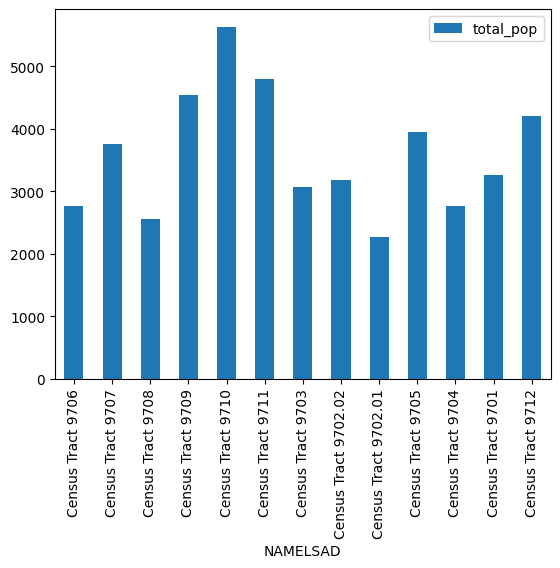

In [ ]:
# using geopandas plot
#ny_merge.plot()

# shows tract lines, same as above, geo default
#ny_merge.plot(kind="geo")

ny_merge.plot(kind="bar",
              x="NAMELSAD",
              y="total_pop",
              legend=True,
              )


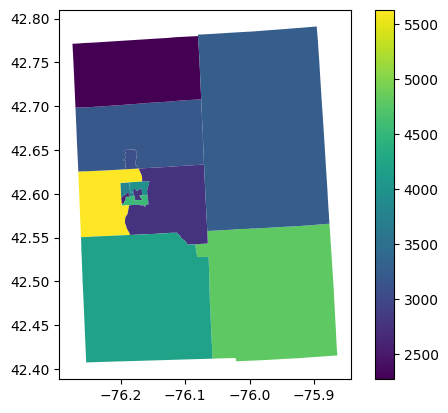

In [ ]:

#ny_merge.plot(column="C17002_002E",
#              legend=True);

ny_merge.plot(column="total_pop",
              legend=True);



In [ ]:
# interactive maps with panda plot, still, using explore

ny_merge.explore(
    column="total_pop",  # make choropleth based on "POP2010" column
    scheme="naturalbreaks",  # use mapclassify's natural breaks scheme
    legend=True,  # show legend
    k=5,  # use 10 bins
    tooltip="NAME_x",  # hide tooltip
    popup=["total_pop"],  # show popup (on-click)
    legend_kwds=dict(colorbar=False),  # do not use colorbar
    name="cortland",  # name of the layer in the map
)



In [ ]:
# layers?
# interactive maps with panda plot, still, using explore

# seems to work, but putting two color schemes in layers, just confuses
# unless they can be toggled

import folium

m = ny_merge.explore(
    column="total_pop",  # make choropleth based on "POP2010" column
    scheme="naturalbreaks",  # use mapclassify's natural breaks scheme
    legend=True,  # show legend
    k=5,  # use 10 bins
    tooltip="NAME_x",  # hide tooltip
    # popup=["total_pop"],  # show popup (on-click)
    popup=True,
    legend_kwds=dict(colorbar=False),  # do not use colorbar
    name="cortland",  # name of the layer in the map
)

ny_merge.explore(
    m=m,  # pass the map object
    column="Income_to_Pov_LT_half",
    name="pov lt half",  # name of the layer in the map
    #legend=True,
    tooltip="NAME_x",
    popup=True
)

#folium.TileLayer("CartoDB positron", show=False).add_to(
#    m
#)  # use folium to add alternative tiles

folium.TileLayer(show=False).add_to(
    m
)  # use folium to add alternative tiles



folium.LayerControl().add_to(m)  # use folium to add layer control

m  # show map


In [ ]:
# setup to experiment with plotly
import plotly.express as px

In [ ]:
display(ny_merge.geometry)

0     POLYGON ((-76.18069 42.60544, -76.17957 42.605...
1     POLYGON ((-76.20049 42.61248, -76.19596 42.612...
2     POLYGON ((-76.19917 42.59558, -76.19900 42.595...
3     POLYGON ((-76.19862 42.58855, -76.19758 42.588...
4     POLYGON ((-76.26561 42.62542, -76.26561 42.625...
5     POLYGON ((-76.08391 42.54237, -76.07777 42.542...
6     POLYGON ((-76.19525 42.63942, -76.19302 42.639...
7     POLYGON ((-76.27001 42.69833, -76.26941 42.698...
8     POLYGON ((-76.27467 42.77126, -76.26814 42.771...
9     POLYGON ((-76.18641 42.61306, -76.18640 42.613...
10    POLYGON ((-76.19321 42.56710, -76.19319 42.569...
11    POLYGON ((-76.08018 42.78043, -76.08017 42.781...
12    POLYGON ((-76.26148 42.55045, -76.25404 42.550...
Name: geometry, dtype: geometry

In [ ]:
# maybe geoid needs to be index

ny_merge.set_index('GEOID', inplace=True)


In [ ]:
# ok this version basically works, so gonna copy and fiddle with copied version


# df_geo_county = df_geo.loc[df_geo['county'] == '025']
fig = px.choropleth_mapbox(ny_merge,
                        #featureidkey="total_pop",
                        geojson=ny_merge.geometry,
                        #geojson = my_geo_json,
                        locations=ny_merge.index,
                        hover_name = ny_merge.NAMELSAD,
                        hover_data = ['total_pop'],
                        color='total_pop',
                        color_continuous_scale='Viridis',
                        opacity=0.5,
                        center={"lat": 42.58, "lon": -76.18},
                        mapbox_style="open-street-map",
                        zoom=8.5,
                        title='test'
                        )
fig.show()

In [ ]:
ny_merge.explore()


In [ ]:


ny_merge.explore(
    column="C17002_003E",  # make choropleth based on "BoroName" column
    tooltip="NAMELSAD",  # show "BoroName" value in tooltip (on hover)
    popup=True,  # show all values in popup (on click)
    style_kwds=dict(color="black"),  # use black outline
)

In [ ]:
#ny_merge.describe()
ny_merge.info()


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   STATEFP      13 non-null     object  
 1   COUNTYFP     13 non-null     object  
 2   TRACTCE      13 non-null     object  
 3   GEOID        13 non-null     object  
 4   NAME_x       13 non-null     object  
 5   NAMELSAD     13 non-null     object  
 6   MTFCC        13 non-null     object  
 7   FUNCSTAT     13 non-null     object  
 8   ALAND        13 non-null     int64   
 9   AWATER       13 non-null     int64   
 10  INTPTLAT     13 non-null     object  
 11  INTPTLON     13 non-null     object  
 12  geometry     13 non-null     geometry
 13  NAME_y       13 non-null     object  
 14  C17002_001E  13 non-null     float64 
 15  C17002_002E  13 non-null     float64 
 16  C17002_003E  13 non-null     float64 
 17  B01003_001E  13 non-null     float64 
 18  state        13 non-null

In [ ]:
ny_merge.explore(
    column="total_pop",  # make choropleth based on "BoroName" column
    tooltip=["NAMELSAD", "total_pop"],  # show "BoroName" value in tooltip (on hover)
    popup=True,  # show all values in popup (on click)
    style_kwds=dict(color="black"),  # use black outline
)

Text(0.5, 1.0, 'total population')

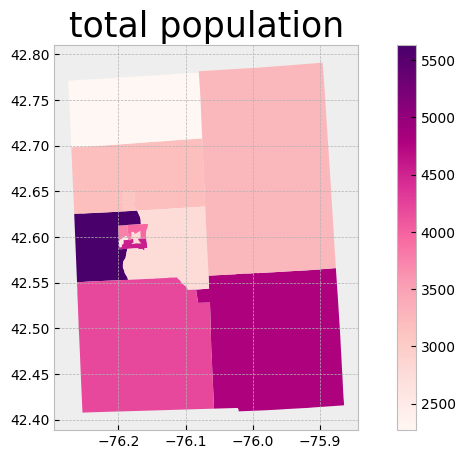

In [ ]:

# Create subplots
fig, ax = plt.subplots(1, 1, figsize = (10, 5))

# Plot data
# Source: https://geopandas.readthedocs.io/en/latest/docs/user_guide/mapping.html
ny_merge.plot(column = "total_pop",
                       ax = ax,
                       cmap = "RdPu",
                       legend = True)

# Stylize plots
plt.style.use('bmh')

# Set title
ax.set_title('total population', fontdict = {'fontsize': '25', 'fontweight' : '3'})


In [ ]:

#14  C17002_001E  13 non-null     float64
# 15  C17002_002E  13 non-null     float64
# 16  C17002_003E  13 non-null     float64
# 17  B01003_001E  13 non-null     float64


# df_geo_county = df_geo.loc[df_geo['county'] == '025']
fig = px.choropleth_mapbox(ny_merge,
                        geojson=ny_merge.geometry,
                        locations=ny_merge.index,
                        hover_name = ny_merge.NAMELSAD,
                         hover_data={
                              'C17002_002E': True,
                              'C17002_003E':True, # add other column, default formatting
                              'total_pop':True,
                              'NAME_x':True   },
                        color='total_pop',
                        color_continuous_scale='Viridis',
                        opacity=0.25,
                        center={"lat": 42.58, "lon": -76.18},
                        mapbox_style="open-street-map",
                        zoom_control = True,
                        zoom=8.5,
                        title='test'
                        )
fig.show()

NameError: name 'px' is not defined

# Various test plots

In [ ]:
# quick map test
import math # move to setup?

def create_pop (r):
  popup_mes = (r.NAME + '<br> '
            + 'INCOME: ' + str(r.INCOME_AMT) + '<br> '
            + 'EIN: ' + str(r.EIN))
  return popup_mes


m = folium.Map(
    location=[42.5,-76],
    zoom_start=10
)


#for r in cortland_gdf.itertuples():
for r in cortland_df.itertuples():
  #print (r.NAME, r.coord_x)
  if not math.isnan(r.coord_x):  # the data has po boxes with no lat long
    folium.CircleMarker(location=[r.coord_y, r.coord_x],
                  radius=10,
                  #color='crimson',
                  fill=True,
                  fill_color='crimson',
                  fill_opacity=0.2,
                  toolbar=r.NAME ,
                  popup=folium.Popup(create_pop(r)),
                  tooltip=r.NAME
                  ).add_to(m)

folium.LayerControl().add_to(m)

m



In [ ]:
# verify that the nonprofits do plot
# cortland_gdf.plot()


cortland_gdf.explore(
    #column="total_pop",  # make choropleth based on "POP2010" column
    #scheme="naturalbreaks",  # use mapclassify's natural breaks scheme
    legend=True,  # show legend

    tooltip="NAME",  # hide tooltip
    popup=True,  # show popup (on-click), all the columns
    # legend_kwds=dict(colorbar=False),  # do not use colorbar
    name="cortland",  # name of the layer in the map
)


In [ ]:
# https://geopandas.org/en/latest/gallery/plotting_with_folium.html

import math

m = folium.Map(
    location=[42.5,-76],
    zoom_start=10
)

# Create a geometry list from the GeoDataFrame
# geo_df_list = [[point.xy[1][0], point.xy[0][0]] for point in cortland_gdf.geometry]


# these steps seem unnecessary.  I already have a geopandas dataframe with both lat lon
# and point geometry

# the df['column'][i] syntax also seems like yet another way, unnecessarily
# must be missing something

geo_df_list = []
for point in cortland_gdf.geometry:
  if point:
    geo_df_list.append( [point.xy[1][0], point.xy[0][0] ])

#print (geo_df_list)

# Iterate through list and add a marker each np, maybe colorcode by income.
i = 0
for coordinates in geo_df_list:
  print (coordinates, type(coordinates))
  #print (geo_df_list[i])
  # assign a color marker for the type of volcano, Strato being the most common
  '''
  if geo_df.Type[i] == "Stratovolcano":
      type_color = "green"
  elif geo_df.Type[i] == "Complex volcano":
      type_color = "blue"
  elif geo_df.Type[i] == "Shield volcano":
      type_color = "orange"
  elif geo_df.Type[i] == "Lava dome":
      type_color = "pink"
  else:
      type_color = "purple"
  '''
  # Place the markers with the popup labels and data
  m.add_child(
    folium.Marker(
        location=coordinates,
        popup= cortland_gdf.NAME[i],
        tooptip= cortland_gdf.NAME[i],
        #icon=folium.Icon(color="%s" % type_color),
      )
    )

  i = i + 1

m


[42.60265545672596, -76.16581817928142] <class 'list'>
[42.64064698217434, -76.26954957518406] <class 'list'>
[42.60258725993801, -76.16138995675283] <class 'list'>
[42.57731981452921, -76.21347828363149] <class 'list'>
[42.59611174182402, -76.18260653449012] <class 'list'>
[42.58560043308098, -76.21917535617905] <class 'list'>
[42.60392541422453, -76.18223301667501] <class 'list'>
[42.59868124037384, -76.18026470408532] <class 'list'>
[42.62355591685019, -76.19278848853179] <class 'list'>
[42.59294122987776, -76.18790930443951] <class 'list'>
[42.62389239702869, -76.15616879769264] <class 'list'>
[42.60111702871816, -76.1809676855583] <class 'list'>
[42.59959030839212, -76.1804692555495] <class 'list'>
[42.60657372078813, -76.18598625185302] <class 'list'>
[42.59687910322157, -76.18161569378717] <class 'list'>
[42.59805637461092, -76.18146567160723] <class 'list'>
[42.59547728406299, -76.19362857397175] <class 'list'>
[42.60278676427825, -76.18475108351994] <class 'list'>
[42.59970265

# Map Census Tracts with NPs

## feature group*

In [ ]:
from urllib.request import url2pathname
#  ------------- Census Tracts with NPs added in feature group
# https://python-visualization.github.io/folium/latest/getting_started.html


#TODO:  add data for tracts (eg. population, poverty, median income)
#TODO:  divide NPs by layers by... NTEE?
#TODO:  for mult poss codes, like NTEE, activity, add logic to include
#TODO:  Add lists beneath plot of details
#TODO:  in popup, can i add links to elected reps, since codes are there
#TODO:  street view in popup would be fun
#TODO:  collect web address from 990
#TODO:  launch explorations map -- would be more conducive with SPARQL?
#TODO:  populate cortland_df with more NPs, maybe by zip or...
#       50 mile radius based on geocode distances, prob not realistic
#       still, could use other apis to find appropriate zipcodes
#TODO:  Divide notebooks between generating/saving datasets and reading/plotting datasets

import math

m = folium.Map(
    location=[42.5,-76],
    zoom_start=10
)

# you can pass gdf to geojson
folium.GeoJson(tracts_cc_gpd,
              fill_opacity=0.1,
               popup=folium.GeoJsonPopup(fields=['NAME']),
               name="Census Tracts").add_to(m)


'''
# this works, too
folium.GeoJson(cortland_gdf,
               style_function=lambda x: { 'radius' : '10',
                                   'color': 'black',
                                   'fillOpacity': 0.75},
               popup=folium.GeoJsonPopup(fields=['NAME']),
               marker_kwds=dict(radius=5, fill=True),
               name="Nonprofits").add_to(m)
'''
# about iterating lat/lon markers, mayebe put into feature group or layer

# put NPs in a feature group or layer (what's the difference?)
group_1 = folium.FeatureGroup("NPs").add_to(m)

def get_popup (row):
  import math

  #TODO: put logic to skip nulls, notate which website, etc
  #TODO: use api.congress.gov to get stuff, https://www.congress.gov/help/using-data-offsite
  # key saved in secrets
  # https://api.congress.gov/v3/member/MI/10?api_key=[INSERT_KEY]
  # https://api.congress.gov/v3/member/NY/19?api_key=pYKHRuu4IQNyahFhDLEeiCGJhCILctRhjY6QdYVA

  # -- ny state legislature links --
  # TODO: check census to see if it can deliver link ready value
  # assumes consistency
  #senate link format: https://www.nysenate.gov/district/48
  #data format:  State (Upper): 	State Senate District 48
  legup_link_parts = row.legup_NAME.split(' ')

  #https://www.nysenate.gov/district/48
  legup_link = (f"<a href=\"https://www.nysenate.gov/district/{legup_link_parts[-1]}\" "
                f"target=\"_blank\"> {row.legup_NAME} </a>")


  # format for assembly:  https://www.assembly.state.ny.us/mem/?ad=125&sh=about
  # data format:  Assembly District 125
  leglow_link_parts = row.leglow_NAME.split(' ')
  leglow_link = (f"<a href=\"https://www.assembly.state.ny.us/mem/?ad={leglow_link_parts[-1]}&sh=about\" "
                f"target=\"_blank\"> {row.leglow_NAME} </a>")

  # get congressional distict info
  # district_dict[dist] loaded previously
  cong_dist_url = district_dict[row.cong_NAME]['house_url']
  cong_mbr_name = district_dict[row.cong_NAME]['name']
  cong_dist_link = (f' <a href=\"{cong_dist_url}\" '
                f'target=\"_blank\"> {row.cong_NAME} - {cong_mbr_name}</a> ')


  # website
  if not pd.isnull(row.WebsiteAddressTxt):
    if row.WebsiteAddressTxt == 'tag_not_found':
      web_url = (f'<a href=\"{row.url}\" '
               f' target=\"_blank\"> {row.found_name} (web search) </a>')
    else:
      web_url = (f'<a href=\"https://{row.WebsiteAddressTxt}\" '
                f' target=\"_blank\"> {row.WebsiteAddressTxt} (IRS)</a>')
  elif not pd.isnull(row.url):
    web_url = (f'<a href=\"{row.url}\" '
               f' target=\"_blank\"> {row.found_name} (web search) </a>')
  else:
    web_url = 'No Website Found'

  # format for guidestar 12-23456789
  ein = str(row.EIN)
  ein2 = ein[:2]
  ein7 = ein[2:9]
  return (f'<div>'
    f'<table class="table table-striped table-hover table-condensed table-responsive">'
    f'<tr> '
    f'<td> Name:</td> <td>  {row.NAME} </td> '
    f'</tr> '
    f'<tr> '
    f'<td> Post Addr:</td> <td> {row.STREET}, {row.CITY} </td> '
    f'</tr> '
    f'<tr> '
    f'<td> IRS Contact:</td> <td> {row.ICO} </td> '
    f'</tr> '

    f'<tr> '
    f'<td> EIN:</td> <td> {row.EIN} </td> '
    f'</tr> '

    f'<tr> '
    f'<td colspan=2> '
    f'<a href=https://projects.propublica.org/nonprofits/organizations/{row.EIN} '
    f' target=\"_blank\">Propublic &#8594; </a> <br>'

    f'<a href=https://www.guidestar.org/profile/{ein2}-{ein7} '
    f' target=_\"blank\"  >Guidestar &#8594;</a> <br>'

    f'<a href=https://www.causeid.com/{row.EIN}>CauseIQ </a> <br>'
    f'<a href=https://eintaxid.com/company/{row.EIN}>EIN Tax ID</a>'

    f'   </td> '
    f'</tr> '

    f'<tr> '
    f'<td> INCOME AMT:</td> <td> {row.INCOME_AMT} </td> '
    f'</tr> '
    f'</tr> '
    f'<td> NTEE:</td> <td> {row.ntee_cat} </td> '
    f'</tr> '
    f'<tr> '
    f'<td> Org Type:</td> <td> 501c({row.SUBSECTION}) {row.org_lu} </td> '
    f'</tr> '
    f'<tr> '
    f'<td> Activities:</td> <td> {row.act1_lu} </td> '
    f'</tr> '
    f'<tr> '
    f'<td> SubName:</td> <td> {row.cntysub_NAME} </td> '
    f'</tr> '

    f'<tr> '
    f'<td> Foundation Category:</td> <td> {row.found_lu} </td> '
    f'</tr> '

    f'<tr> '
    f'<td> State (Upper):</td> <td>  {legup_link} &#8594; </td> '
    f'</tr> '
    f'<tr> '
    f'<td> State (Lower):</td> <td> {leglow_link} &#8594; </td> '
    f'</tr> '
    f'<tr> '
    f'<td> Congress Dist:</td> <td> '
    f' {cong_dist_link} &#8594;'
    f'</td> '
    f'</tr> '

    f'<tr> '
    f'<td> Senate:</td> <td> '
    f' <a href=\"https://www.senate.gov/states/NY/intro.htm\" '
    f' target=\"_blank\">Senators in NY</a> &#8594; '
    f' </td> '
    f'</tr> '



    f'<tr> '
    f'<td> Website:</td> <td> {web_url} &#8594; '
    f'  </td> '
    f'</tr> '

    f'<tr> '
    f'<td> Mission:</td> <td> {row.Mission} </td> '
    f'</tr> '
    f'<tr> '
    f'<td> Accomplishments:</td> <td> {row.ProgramSrvcAccomplishmentGrp} </td> '
    f'</tr> '
    f'<tr> '
    f'<td> Programming:</td> <td> {row.Pgm_Serv_Accomps} </td> '
    f'</tr> '

  f'</table> '
  f'</div>')


# um, inconsistent popup, keeps giving federal teachers...
#style=overflow-x:auto;
html = (f'<div>'
        f'<table class="table table-striped table-hover table-condensed table-responsive">'
        f'</div>')


#    classes="table table-striped table-hover table-condensed table-responsive")

# itertuples, items, iterrows
#for index, row in cortland_df.iterrows():
for index, row in cortland_geotaxweb_df.iterrows():


#for index, row in cortland_gdf.iterrows():
  #print(row['STREET'], row['CITY'], row['STATE'], row['ZIP'])
  #print (row['coord_x'], row['coord_y'] )
  if not math.isnan(row['coord_x']):  # the data has po boxes with no lat long

    folium.CircleMarker(
        location=[  row['coord_y'], row['coord_x'] ],
        #folium.Marker(location=[ row['coord_x'], row['coord_y'] ],
        fill=True,
        #popup=row['NAME'],
        #popup=folium.Popup(row['NAME']),
        #popup=folium.Popup(html),
        popup=folium.Popup(get_popup(row), max_width=300),
        #tooltip=row['NAME'],
        tooltip = row.NAME,
        #radius=15,
      # fill_color="#3db7e4"
        ).add_to(group_1)

# '''

folium.LayerControl().add_to(m)

m

#m.save("testmap.html")


In [ ]:
display(tracts_cc_gpd)

NameError: name 'tracts_cc_gpd' is not defined

## using explore, passing m=m

In [ ]:
# ---- Tracts and Cortland NPs as explore ------
# can layer in by passing map object
# order matters, as tracts can cover the NPs
# TODO:  more control over markers

#TODO: transparency on tracts
# controlling popups formatting

# filter for census tracts in cortland county

tracts_cc_gpd = tracts_gpd[tracts_gpd['COUNTYFP'] == '023']

m = folium.Map(
    location=[42.5,-76],
    zoom_start=10
)

# '''
# using boundary makes popup in tract not work
tracts_cc_gpd.explore(
    m=m,
    #column="Income_to_Pov_LT_half",
    name="tracts",  # name of the layer in the map
    #legend=True,
    fill = True,
    fill_opacity=0.01,  # makes no difference
    tooltip="NAME",
    #tooltip=False,
    popup=True,
    #popup=False
)

# '''

# '''
cortland_gdf.explore(
    m=m,  # pass the map object
    #column="total_pop",  # make choropleth based on "POP2010" column
    #scheme="naturalbreaks",  # use mapclassify's natural breaks scheme
    legend=True,  # show legend
    tooltip="NAME",
    # opacity=".01",
    tooltip_kwds=dict(labels=False), # do not show column label in the tooltip
    marker_kwds=dict(radius=10, fill=True),
    popup=True,  # show popup (on-click)
    # legend_kwds=dict(colorbar=False),  # do not use colorbar
    name="Cortland NPs",  # name of the layer in the map
    # mapbox_style="open-street-map",
    zoom_control = True,
    #zoom=8.5,
    # title='test'
)
# '''

'''
# iterating points
for row in cortland_df.itertuples():
  if not math.isnan(row.coord_x):  # the data has po boxes with no lat long
    folium.Marker(location=[row.coord_y, row.coord_x]).add_to(m)
'''


#folium.TileLayer("CartoDB positron", show=False).add_to(
#    m
#)  # use folium to add alternative tiles

folium.TileLayer(show=False).add_to(m)  # use folium to add alternative tiles

folium.LayerControl().add_to(m)  # use folium to add layer control

m  # show map



ImportError: The 'folium', 'matplotlib' and 'mapclassify' packages are required for 'explore()'. You can install them using 'conda install -c conda-forge folium matplotlib mapclassify' or 'pip install folium matplotlib mapclassify'.

## using def for popup

# plot lat lon tests

In [ ]:
%pip install cartopy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 42.4 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


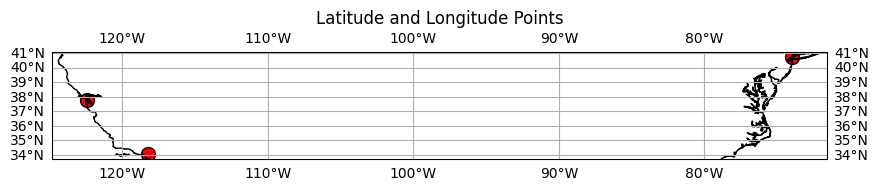

In [ ]:
# test plot lat lon

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Sample latitude and longitude data
latitudes = [37.7749, 34.0522, 40.7128]  # San Francisco, Los Angeles, New York
longitudes = [-122.4194, -118.2437, -74.0060]

# Create a figure with a specified projection
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add features to the map
ax.coastlines()
ax.gridlines(draw_labels=True)

# Plot the points
ax.scatter(longitudes, latitudes, color='red', s=100, edgecolor='black')

# Add a title
plt.title('Latitude and Longitude Points')

# Display the map
plt.show()



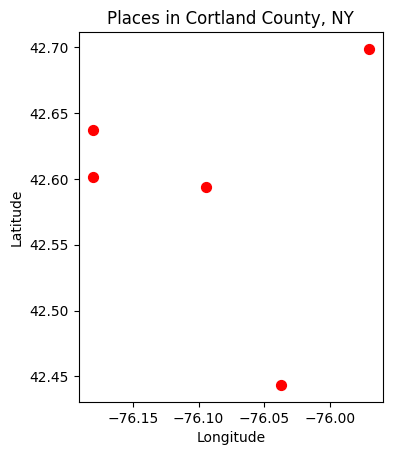

In [ ]:
#import matplotlib.pyplot as plt
#import geopandas as gpd
from shapely.geometry import Point

# Sample latitude and longitude data for places in Cortland County, NY
places = {
    "Cortland": (42.6012, -76.1805),
    "Homer": (42.6370, -76.1799),
    "Marathon": (42.4436, -76.0377),
    "McGraw": (42.5942, -76.0947),
    "Truxton": (42.6987, -75.9705)
}

# Create a GeoDataFrame
geometry = [Point(lon, lat) for lat, lon in places.values()]
gdf = gpd.GeoDataFrame(places.keys(), geometry=geometry, columns=["Place"])

# Plot using GeoPandas
gdf.plot(marker='o', color='red', markersize=50)

# Add title and labels
plt.title("Places in Cortland County, NY")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Display the map
plt.show()


In [ ]:
%pip install contextily

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 73.9 MB/s eta 0:00:00


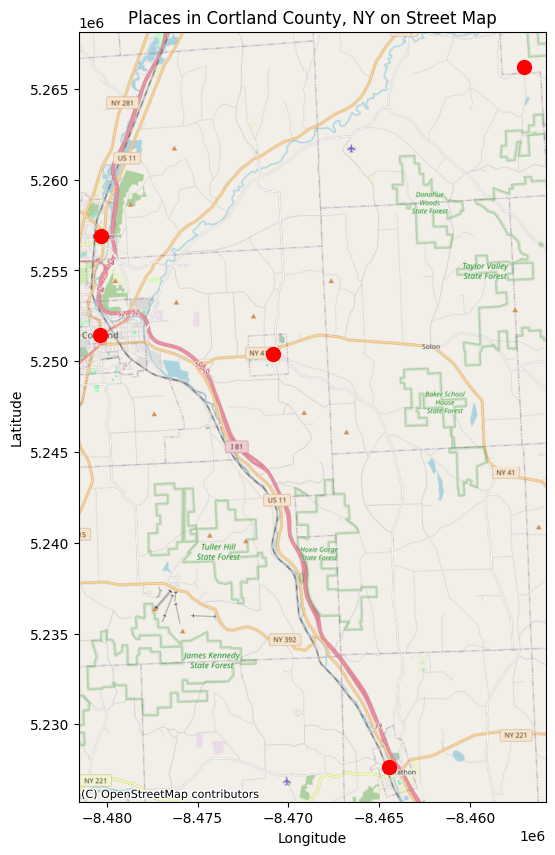

In [ ]:
# simple plot with ax

import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx

# Sample latitude and longitude data for places in Cortland County, NY
places = {
    "Cortland": (42.6012, -76.1805),
    "Homer": (42.6370, -76.1799),
    "Marathon": (42.4436, -76.0377),
    "McGraw": (42.5942, -76.0947),
    "Truxton": (42.6987, -75.9705)
}

# Create a GeoDataFrame
geometry = [Point(lon, lat) for lat, lon in places.values()]
gdf = gpd.GeoDataFrame(places.keys(), geometry=geometry, columns=["Place"])

# Set the coordinate reference system to WGS84 (lat/lon)
gdf = gdf.set_crs(epsg=4326)

# Convert to Web Mercator (EPSG:3857) for compatibility with contextily basemaps
gdf = gdf.to_crs(epsg=3857)

# Plot the points
ax = gdf.plot(marker='o', color='red', markersize=100, figsize=(10, 10))

# Add the basemap (street map)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Add title and labels
plt.title("Places in Cortland County, NY on Street Map")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Display the map
plt.show()


In [ ]:
# --------- GET PLACE -----------------
# get place names using census api
# ---------------------------

base_url = 'https://api.census.gov/data'
year = '2022'
state = '36'
county = '023'
dataset = 'acs/acs5'
cols = 'NAME'
#B17001_001E

#https://api.census.gov/data/2022/acs/acs5?get=NAME&for=place:*&in=state:{stateCode}&key={apiKey}

full_url = f'{base_url}/{year}/{dataset}?get={cols}&for=place:*&in=state:{state}&key={ckey}'

print (full_url)
response=requests.get(full_url)
pprint.pprint(response.json())



https://api.census.gov/data/2022/acs/acs5?get=NAME&for=place:*&in=state:36&key=c4dd4253d7612ea36d9b19e4ef12b5742268a4c3


ConnectTimeout: HTTPSConnectionPool(host='api.census.gov', port=443): Max retries exceeded with url: /data/2022/acs/acs5?get=NAME&for=place:*&in=state:36&key=c4dd4253d7612ea36d9b19e4ef12b5742268a4c3 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x7993385a1d80>, 'Connection to api.census.gov timed out. (connect timeout=None)'))

In [ ]:
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point

# Load the census tracts shapefile for Cortland County
tracts = gpd.read_file("path_to_your_shapefile/cortland_tracts.shp")

# Sample latitude and longitude data for places in Cortland County, NY
places = {
    "Cortland": (42.6012, -76.1805),
    "Homer": (42.6370, -76.1799),
    "Marathon": (42.4436, -76.0377),
    "McGraw": (42.5942, -76.0947),
    "Truxton": (42.6987, -75.9705)
}

# Create a GeoDataFrame for the points
geometry = [Point(lon, lat) for lat, lon in places.values()]
gdf_places = gpd.GeoDataFrame(places.keys(), geometry=geometry, columns=["Place"])

# Set the coordinate reference system to WGS84 (lat/lon)
gdf_places = gdf_places.set_crs(epsg=4326)

# Convert to the same CRS as the tracts data
gdf_places = gdf_places.to_crs(tracts.crs)

# Plot the census tracts
ax = tracts.plot(figsize=(10, 10), color='lightgrey', edgecolor='black')

# Plot the points on top of the tracts
gdf_places.plot(ax=ax, marker='o', color='red', markersize=100)

# Optionally add a basemap
# import contextily as ctx
# ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Add title and labels
plt.title("Places in Cortland County, NY on Census Tracts")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show the plot
plt.show()


# plot dataframe with lat lat


In [ ]:
# experiment with getting and saving files in shape file

import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point

# Use Census API to get tracts
year = '2022'
state = '36'
county = '023'

# Step 3: Load the census tracts shapefile for Cortland County
# tracts = gpd.read_file("path_to_your_shapefile/cortland_tracts.shp")

# https://www2.census.gov/geo/tiger/TIGER2022/TRACT/tl_2022_36_tract.zip

#tracts = gpd.read_file(f"https://www2.census.gov/geo/tiger/TIGER{year}/TRACT/tl_{year}_{state}_tract.zip")

#tracts.to_csv('/content/drive/My Drive/IRS_geocode/cortland_tracts. - zip)

#tracts.to_file('/content/drive/My Drive/IRS_geocode/tracts.zip')

# tracts = gpd.read_file('/content/drive/My Drive/IRS_geocode/cortland_tracts.zip')

# https://www2.census.gov/geo/tiger/TIGER2022/TRACT/tl_2022_36_tract.zip

#tracts = gpd.read_file(f"https://www2.census.gov/geo/tiger/TIGER{year}/TRACT/tl_{year}_{state}_tract.zip")




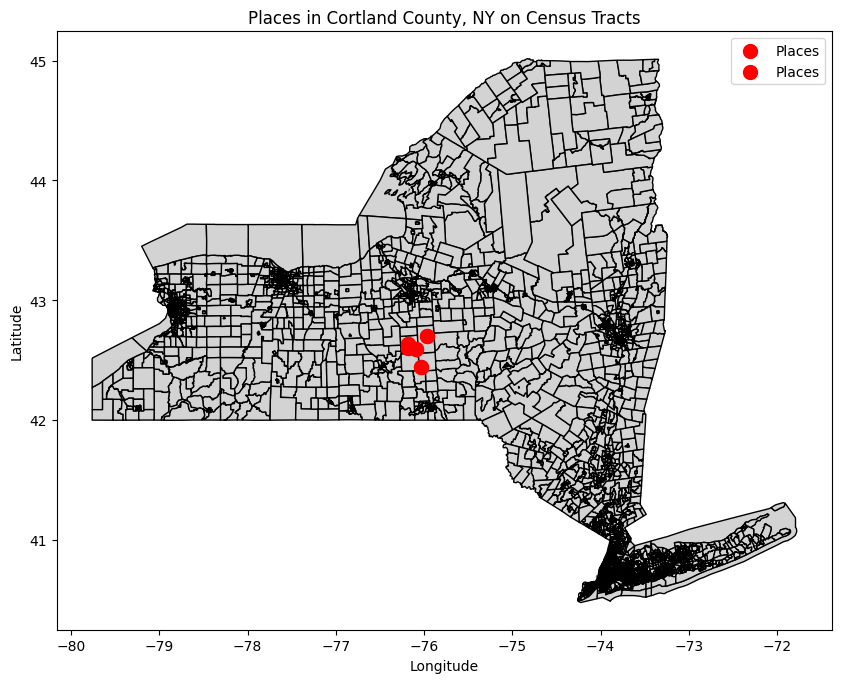

In [ ]:
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point

# Use Census API to get tracts
year = '2022'
state = '36'
county = '023'

# Step 3: Load the census tracts shapefile for Cortland County
# tracts = gpd.read_file("path_to_your_shapefile/cortland_tracts.shp")

# tl_2022_36_tract.shp

#tracts = gpd.read_file(f"https://www2.census.gov/geo/tiger/TIGER{year}/TRACT/tl_{year}_{state}_tract.zip")

# hm.  learning structure of these files
# tracts.to_csv('/content/drive/My Drive/IRS_geocode/cortland_tracts. - zip)
# tracts.to_file('/content/drive/My Drive/IRS_geocode/tracts.zip')


# putting the other files (shx, prj, etc, into same folder works)
tracts = gpd.read_file('/content/drive/My Drive/IRS_geocode/tl_2022_36_tract.shp')


# Step 4: Create a GeoDataFrame for your places (example data)
places_data = {
    'Place': ['Cortland', 'Homer', 'Marathon', 'McGraw', 'Truxton'],
    'Latitude': [42.6012, 42.6370, 42.4436, 42.5942, 42.6987],
    'Longitude': [-76.1805, -76.1799, -76.0377, -76.0947, -75.9705]
}

# Convert to a GeoDataFrame
places_gdf = gpd.GeoDataFrame(
    places_data,
    geometry=[Point(xy) for xy in zip(places_data['Longitude'], places_data['Latitude'])],
    crs="EPSG:4326"  # WGS 84
)

# Step 5: Ensure the coordinate reference system matches the tracts data
places_gdf = places_gdf.to_crs(tracts.crs)

# Step 6: Plot the census tracts
ax = tracts.plot(figsize=(10, 10), color='lightgrey', edgecolor='black')

# Plot the places on top of the census tracts
places_gdf.plot(ax=ax, marker='o', color='red', markersize=100, label="Places")

# places_gdf.explore()

places_gdf.plot(ax=ax, marker='o', color='red', markersize=100, label="Places")



'''
ny_merge.explore(
    column="total_pop",  # make choropleth based on "POP2010" column
    scheme="naturalbreaks",  # use mapclassify's natural breaks scheme
    legend=True,  # show legend
    k=5,  # use 10 bins
    tooltip="NAME_x",  # hide tooltip
    popup=["total_pop"],  # show popup (on-click)
    legend_kwds=dict(colorbar=False),  # do not use colorbar
    name="cortland",  # name of the layer in the map
)
'''


# Add title and labels
plt.title("Places in Cortland County, NY on Census Tracts")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Optionally, add a legend
plt.legend()

# Show the plot
plt.show()


# experiments with census, etc

In [ ]:
# display(cities_df)

print ("Nulls: ", cities_df['PLACEFP'].isnull().sum())


Nulls:  1039


In [ ]:
ny_census = c.acs5.state_county_tract(fields = ('NAME', 'C17002_001E', 'C17002_002E', 'C17002_003E', 'B01003_001E'),
                                      #state_fips = states.VA.fips,
                                      state_fips = "36",
                                      county_fips = "023",
                                      tract = "*",
                                      year = 2022)

display(ny_census)




In [ ]:
display(df)

Layer            GEOID      CENTLAT  \
0     2020 Census Public Use Microdata Areas          1100106  +38.8642235   
1      2020 Census ZIP Code Tabulation Areas            20006  +38.8984817   
2                                Urban Areas            92242  +38.8953351   
3                        Incorporated Places          1150000  +38.9047586   
4                                   Counties            11001  +38.9047586   
5                   Unified School Districts          1100030  +38.9047586   
6                         2020 Census Blocks  110019800001034  +38.8970383   
7                     Metropolitan Divisions       4790047764  +38.6446177   
8                                     States               11  +38.9047586   
9                        Census Block Groups     110019800001  +38.8801546   
10                Combined Statistical Areas              548  +38.9848377   
11                       County Subdivisions       1100150000  +38.9047586   
12                          Census Divisions                5  +33.7954697   
13  2022 State Legislative Districts - Upper            11002  +38.9000369   
14                            Census Regions                3  +33.5118953   
15            Metropolitan Statistical Areas            47900  +38.8312002   
16             118th Congressional Districts             1198  +38.9047586   
17                             Census Tracts      11001980000  +38.8801546   

       AREAWATER                                        BASENAME STATE  \
0       14153010            District of Columbia (South Central)    11   
1              0                                           20006   NaN   
2       67553988               Washington--Arlington, DC--VA--MD   NaN   
3       18709787                                      Washington    11   
4       18709787                            District of Columbia    11   
5       18709787             District of Columbia Public Schools    11   
6              0                                            1034    11   
7      540086987                               Washington, DC-MD   NaN   
8       18709787                            District of Columbia    11   
9        4996393                                               1    11   
10    5216650941  Washington-Baltimore-Arlington, DC-MD-VA-WV-PA   NaN   
11      18709787                                      Washington    11   
12   86332926783                                  South Atlantic   NaN   
13       3029411                                               2    11   
14  148770755322                                           South   NaN   
15     782768496    Washington-Arlington-Alexandria, DC-VA-MD-WV   NaN   
16      18709787                    Delegate District (at Large)    11   
17       4996393                                            9800    11   

                 OID LSADC FUNCSTAT     INTPTLAT  ... DIVISION  REGION COUSUB  \
0   2177029550539712    P0        S  +38.8705434  ...      NaN     NaN    NaN   
1    221704257714593    Z5        S  +38.8984817  ...      NaN     NaN    NaN   
2     27021158105937    67        S  +38.8959429  ...      NaN     NaN    NaN   
3     27890331283927    25        N  +38.9042474  ...      NaN     NaN    NaN   
4     27590331264532    00        F  +38.9042474  ...      NaN     NaN    NaN   
5     28490331329267    00        E  +38.9042474  ...      NaN     NaN    NaN   
6    210701008444240    BK        S  +38.8970383  ...      NaN     NaN    NaN   
7   2639034687908187    M3        S  +38.6444339  ...      NaN     NaN    NaN   
8     27490331294090    00        A  +38.9042474  ...        5       3    NaN   
9   2089015504267429    BG        S  +38.8809933  ...      NaN     NaN    NaN   
10  2619034687908147    M0        S  +38.9854484  ...      NaN     NaN    NaN   
11    27690331274806    25        F  +38.9042474  ...      NaN     NaN  50000   
12     2739020719808    69        S  +33.7948282  ...        5       3    NaN   
13  21290318077

In [ ]:
display(t_df)

result
0  {'input': {'address': {'address': '1600 Pennsy...

In [ ]:
# --- test census geocodader online address ---
import requests

def get_census_place_fips(address, api_key):
    # Base URL for the Census Geocoding API
    base_url = "https://geocoding.geo.census.gov/geocoder/locations/onelineaddress"

    # Set up the parameters for the API request
    params = {
        'address': address,
        'benchmark': 'Public_AR_Current',  # Use the current benchmark
        'format': 'json',
        'key': api_key
    }

    # Send a GET request to the API
    response = requests.get(base_url, params=params)

    # Check if the response was successful
    if response.status_code == 200:
        data = response.json()

        # Check if the API returned a result
        if data['result']['addressMatches']:
            fips_code = data['result']['addressMatches'][0]['geographies']['Census Places'][0]['GEOID']
            return fips_code
        else:
            return "No matches found for the address."
    else:
        return f"Error: {response.status_code}"

# Example usage
api_key = 'your_census_api_key_here'
address = '1600 Pennsylvania Ave NW, Washington, DC 20500'
fips_code = get_census_place_fips(address, api_key)
print(f"Census Place FIPS code: {fips_code}")


## quick lookup

In [ ]:
# quick lookups, various census urls
import requests
import pprint
from google.colab import userdata
ckey = userdata.get('census_api_key')

base_url = 'https://api.census.gov/data'
year = '2022'
state = '36'
county = '023'
dataset = 'acs/acs5'
cols = 'NAME,B01001_001E,B01003_001E'
#B17001_001E

# full_url = f'{base_url}/{year}/{dataset}?get={cols}&for=county:{county}&in=state:{state}&key={ckey}'
# full_url = f'{base_url}/{year}/{dataset}?get={cols}&for=county%20(or%20part):{county}&in=state:{state}%20place:*&key={ckey}'
#full_url = 'https://api.census.gov/data/2022/acs/acs5?get=NAME,B01001_001E,B01003_001E,B17001_001E&for=place:*&in=state:36&key=c4dd4253d7612ea36d9b19e4ef12b5742268a4c3'

# gets nyc
#full_url = 'https://api.census.gov/data/2022/acs/acs5?get=NAME,B01001_001E,B01003_001E,B17001_001E&for=place:51000&in=state:36&key=c4dd4253d7612ea36d9b19e4ef12b5742268a4c3'

place = '18388'
place = '72037'
place = '77596'
# NOTE: cousub is not the same as place
# full_url = f"https://api.census.gov/data/2022/acs/acs5?get=NAME,B01001_001E,B01003_001E&in=state:36&for=place:{place}&key=c4dd4253d7612ea36d9b19e4ef12b5742268a4c3"

cousub = '18388'
place = '72037'
place = '77596'

full_url =  f"https://api.census.gov/data/2022/acs/acs5?get=NAME,B01001_001E&for=county%20(or%20part):{cousub}&in=state:36&key=c4dd4253d7612ea36d9b19e4ef12b5742268a4c3"


#https://api.census.gov/data/2022/acs/acs5?get=NAME,B01001_001E&for=county:*&in=state:*&key=YOUR_KEY_GOES_HERE
#https://api.census.gov/data/2022/acs/acs5?get=NAME,B01001_001E&for=place:*&in=state:*&key=YOUR_KEY_GOES_HERE

print (full_url)
response=requests.get(full_url)
data = response.json()
pprint.pprint(response.json())



https://api.census.gov/data/2022/acs/acs5?get=NAME,B01001_001E&for=county%20(or%20part):18388&in=state:36&key=c4dd4253d7612ea36d9b19e4ef12b5742268a4c3


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [ ]:
# test load df from census call
#print (type(response))
#print (response.json())
data = response.json()
print (type(data))

#  ['West Sand Lake CDP, New York', '3304', '3304', '3304', '36', '80863'],
#NAME,B01001_001E,B01003_001E
#'place', 'state', 'B01001_001E', 'B01003_001E', 'Bx', 'st_fips', 'place_fips'

#'''
import json
import pandas as pd
#data = pd.DataFrame(json.loads(data.text)[1:], columns=['NAME', 'P013001', 'P037001', 'state'])

t_df = pd.DataFrame(json.loads(response.text)[1:], columns=['place',  'B01001_001E', 'B01003_001E', 'st_fips', 'place_fips'])
display(t_df)
#'''



<class 'list'>


place B01001_001E B01003_001E st_fips  \
0               Accord CDP, New York         350         350      36   
1            Adams village, New York        1923        1923      36   
2         Adams Center CDP, New York        1022        1022      36   
3          Addison village, New York        1841        1841      36   
4            Afton village, New York        1159        1159      36   
...                              ...         ...         ...     ...   
1288         Yorkshire CDP, New York        1057        1057      36   
1289  Yorktown Heights CDP, New York        2147        2147      36   
1290     Yorkville village, New York        2635        2635      36   
1291    Youngstown village, New York        1965        1965      36   
1292              Zena CDP, New York         726         726      36   

     place_fips  
0         00155  
1         00199  
2         00232  
3         00276  
4         00342  
...         ...  
1288      84044  
1289      84088  
1290      84099  
1291      84143  
1292      84187  

[1293 rows x 5 columns]

In [ ]:
# DRAFT 1:  Prepping tax returns to add to BMF

# how to match Tax forms to BMF
# EIN is a good start

# find duplicate EINs
# the 990T, maybe ignore

#option: collect multiple rows/values in a dict add to BMF
# vectorize??

# option: just get last return, aka 1 return for each org in BMG

# --- quick checks ------
# combined_df.shape
# (341082, 37)

# combined_df.info()
# 341082

#filt = combined_df.duplicated(subset=['EIN'])
#combined_df[filt].sort_values(by=['EIN'])
# 19015 rows

# By setting keep on False, all duplicates are True.

# including dupes how many rows have same EIN
#filt = combined_df.duplicated(subset=['EIN'], keep=False)
#combined_df[filt].sort_values(by=['EIN'])
# 36512

#filt = combined_df.duplicated(subset=['EIN', 'TaxYr'])
#combined_df[filt].sort_values(by=['EIN'])
# 9637

# including dupes how many rows have same EIN in same tax year
#filt = combined_df.duplicated(subset=['EIN', 'TaxYr'], keep=False)
#combined_df[filt].sort_values(by=['EIN'])
# 19171

# including dupes how many rows have same EIN in same tax year and same state in address
#filt = combined_df.duplicated(subset=['EIN', 'TaxYr', 'StateAbbreviationCd'], keep=False)
#combined_df[filt].sort_values(by=['EIN'])
#  19158

# throw away 990T
#filt = combined_df['IRS_Form'] != 'IRS990T'
#combined_df = combined_df[filt]  # woops
#combined_df[filt].sort_values(by=['EIN'])
# 331678

# possible to filter both conditions?
#filt =  (
#        (combined_df['IRS_Form'] != 'IRS990T') &
#        (combined_df.duplicated(subset=['EIN', 'TaxYr', 'StateAbbreviationCd'], keep=False))
#        )
#combined_df[filt].sort_values(by=['EIN'])
# 10908

# test by firist
# filt = combined_df['IRS_Form'] != 'IRS990T'
# IRS_Returns_df = combined_df[filt]
# display(IRS_Returns_df)
# 331678


# these seem like legit dupes
#filt = IRS_Returns_df.duplicated(subset=['EIN', 'TaxYr', 'StateAbbreviationCd'], keep=False)
#IRS_Returns_df[filt].sort_values(by=['EIN'])
# 2711

# look at file names...
# these are same exact for CYTotalRevenueAmt
#2024 20399349301402_public.xml, 721115
#2024 40329349300614_public.xml, 719684
# ein 10558856

# propublica says  $719,684
#https://projects.propublica.org/nonprofits/search?q=10558856
# so:  get the greater filename number...

# also, in case there are multiple years
# for now, just want to get latest , in case multiple years

# steps summary
# thowaway 990T
# sort by ein, tax year, state (not sure if natl orgs use same EIN), filename
# get the latest one row for these

# SO: https://stackoverflow.com/questions/59523506/how-to-sort-values-by-date-and-drop-duplicates-by-a-column
# df2 = df.sort_values(by=['checkdate']).drop_duplicates('id', keep='last')

# do steps (need to create new df - setting with copy warning)
#IRS_Returns_df.sort_values(by=['EIN', 'TaxYr', 'StateAbbreviationCd', 'filename'], inplace=True)
#IRS_Returns_df.drop_duplicates(subset=['EIN', 'TaxYr', 'StateAbbreviationCd'], keep='last', inplace=True)
#display(IRS_Returns_df)
# 330294

# check - no rows, looks good
#filt = IRS_Returns_df.duplicated(subset=['EIN', 'TaxYr', 'StateAbbreviationCd'], keep=False)
#IRS_Returns_df[filt].sort_values(by=['EIN'])


# check for dupes on EIN, hopefully meaning multiple tax years
# including dupes how many rows have same EIN
#filt = IRS_Returns_df.duplicated(subset=['EIN'], keep=False)
#IRS_Returns_df[filt].sort_values(by=['EIN'])
# 17598


# ok, just get latest tax year
#IRS_Returns_df.sort_values(by=['EIN', 'TaxYr'], inplace=True)
#IRS_latest_df = IRS_Returns_df.duplicated(subset=['EIN', 'TaxYr'], keep='last', inplace=True)

#display(IRS_Returns_df)




<ipython-input-44-f84c975a5454>:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  IRS_Returns_df.sort_values(by=['EIN', 'TaxYr'], inplace=True)


filename  IRS_Form TaxPeriodEndDt TaxPeriodBeginDt  \
8591  202431419349201403_public.xml  IRS990EZ     2023-12-31       2023-01-01   
397   202411569349200746_public.xml  IRS990EZ     2023-12-31       2023-01-01   
306   202411419349200011_public.xml  IRS990EZ     2023-12-31       2023-01-01   
1673  202441279349303259_public.xml    IRS990     2023-05-31       2022-06-01   
7690  202421369349305437_public.xml    IRS990     2023-06-30       2022-07-01   
...                             ...       ...            ...              ...   
3977  202441459349100314_public.xml  IRS990PF     2023-12-31       2023-12-29   
8797  202431429349100218_public.xml  IRS990PF     2023-12-31       2023-12-29   
8383  202401499349101105_public.xml  IRS990PF     2023-12-31       2023-12-19   
240   202421149349100807_public.xml  IRS990PF     2023-12-31       2023-12-27   
8815  202431429349100633_public.xml  IRS990PF     2023-12-31       2023-01-01   

      TaxYr ReturnTypeCd        EIN    PhoneNum  \
8591   2023        990EZ   10015091  9733496412   
397    2023        990EZ   10017496  2073638510   
306    2023        990EZ   10018605  2072812017   
1673   2022          990   10018923  2073245354   
7690   2022          990   10024645  2079425555   
...     ...          ...        ...         ...   
3977   2023        990PF  996103790  4012868255   
8797   2023        990PF  996118102  6302153930   
8383   2023        990PF  996131254  2124074000   
240    2023        990PF  996202676  8023341677   
8815   2023        990PF  998010224  8082024515   

                      BusinessNameLine1Txt          AddressLine1Txt  \
8591               HANOVER SOCCER CLUB INC                PO Box 13   
397             AGAMENTICUS YACHT CLUB INC               PO BOX 534   
306              AMALGAMATED TRANSIT UNION               PO BOX 979   
1673               AMERICAN LEGION POST 19               PO BOX 801   
7690             BANGOR SYMPHONY ORCHESTRA              PO BOX 1441   
...                                    ...                      ...   
3977              MARASCO CHARITABLE TRUST         71 FLINTSTONE RD   
8797        THE ROBERT AND CATHERINE PLATT        226 S KENMORE AVE   
8383  THE EDWARD AND CAROLINE HYMAN FAMILY      10 GRACIE SQUARE 9H   
240     BERNICE M CARPENTER SCHOLARSHIP TR               PO BOX 120   
8815       HAWAII FOUNDATION FOR THE BLIND  73-1077 MAKAMAKA STREET   

     AddressLine2Txt        CityNm StateAbbreviationCd      ZIPCd CountryCd  \
8591   tag_not_found  Cedar Knolls                  NJ      07927        US   
397    tag_not_found   YORK HARBOR                  ME      03911        US   
306    tag_not_found      PORTLAND                  ME      04104        US   
1673   tag_not_found       SANFORD                  ME      04073        US   
7690   tag_not_found        BANGOR                  ME  044021441        US   
...              ...           ...                 ...        ...       ...   
3977   tag_not_found  NARRAGANSETT                  RI      02882        US   
8797   tag_not_found      ELMHURST                  IL      60126        US   
8383   tag_not_found      NEW YORK                  NY      10028        US   
240    tag_not_found       NEWPORT                  VT      05855        US   
8815   tag_not_found    KAILUAKONA                  HI      96740        US   

     ProvinceOrStateNm ForeignPostalCd       WebsiteAddressTxt  \
8591                                             tag_not_found   
397                                            WWW.AYCSAIL.ORG   
306                                              tag_not_found   
1673                                             tag_not_found   
7690                                    WWW.BANGORSYMPHONY.ORG   
...                ...             ...                     ...   
3977                                             tag_not_found   
8797                                             tag_not_found   
8383                                         

# review data

In [ ]:
# various checks of addresses, websites, etc


# count rows in cortland_df with null website
null_website_count = cortland_df['WebsiteAddressTxt'].isnull().sum()
print("Number of rows with null website:", null_website_count)

# count rows in cortland_df with null filename (no tax return)
null_filename_count = cortland_df['filename'].isnull().sum()
print("Number of rows with null filename:", null_website_count)

# count rows where STREET starts with 'PO BOX'
po_box_count = cortland_df[cortland_df['STREET'].str.startswith('PO BOX')].shape[0]
print("Number of rows with 'PO BOX' in STREET:", po_box_count)

filt = cortland_df['STREET'].str.startswith('PO BOX')
display(cortland_df[filt])



Number of rows with null website: 102
Number of rows with null filename: 102
Number of rows with 'PO BOX' in STREET: 31


EIN                                               NAME  \
9    150279165                               ROTARY INTERNATIONAL   
14   150508031                    CORTLAND COLLEGE ALUMNI ASS INC   
32   161000951                            GREEK PEAK SKI CLUB INC   
37   161132390            STATEWIDE COUNTRY MUSIC ASSOCIATION INC   
45   161188525                           RALPH WILKINS FOUNDATION   
49   161305817                                ZONTA INTERNATIONAL   
56   161458794                                  FAMILY CONNECTION   
63   161560250                     WESTERN NEW YORK OFFROAD ASSOC   
64   161561037                      CORTLAND COMMUNITY FOUNDATION   
74   166098173  PSI CHI THE INTERNATIONAL HONOR SOCIETY IN PSY...   
75   166103616          CORTLAND SENIOR HIGH SCHOOL BOOSTERS CLUB   
76   166187114                   CORTLAND FIGURE SKATING CLUB INC   
83   204296071                  CORTLAND DOWNTOWN PARTNERSHIP INC   
85   204916565                 UNITED STATES BOWLING CONGRESS INC   
87   208746984          CORTLAND COLLEGE FOUNDATIONPROPERTIES INC   
91   222382232                        HOLY SPIRIT LUTHERAN CHURCH   
94   222839556      MENTAL HEALTH ASSOCIATION FOR CORTLAND COUNTY   
98   237036641             LEAGUE OF WOMEN VOTERS OF NEW YORK INC   
100  237135196                       COMMUNITY FULL GOSPEL CHURCH   
105  237269008            CULTURAL COUNCIL OF CORTLAND COUNTY INC   
107  237424765       CORTLAND COUNTY YOUTH HOCKEY ASSOCIATION INC   
112  261329102            BROCKWAY TRUCK PRESERVATION ASSOCIATION   
117  274000249  NATIONAL CONSORTIUM FOR PHYSICAL EDUCATION FOR...   
123  453126845                  CORTLAND BREAKFAST ROTARY CAC INC   
124  454495541                  BILLY BIMBA GLOBAL MINISTRIES INC   
132  472550038                              WARRIORS OF THE CROSS   
136  571176369                  CORTLAND MAIN STREET MUSIC SERIES   
140  621783876                     HONOR SOCIETY OF PHI KAPPA PHI   
141  680511169          COUNTY POLICE ASSOCIATION OF CORTLAND INC   
149  853093400                         FINCH RESEARCH NETWORK INC   
150  853115382             NATIVE ORCHID CONSERVATION NETWORK INC   

                             ICO       STREET      CITY STATE         ZIP  \
9               % CLUB PRESIDENT  PO BOX 5248  CORTLAND    NY  13045-5248   
14                           NaN  PO BOX 2000  CORTLAND    NY  13045-0900   
32       % AMY DERITO -TREASURER  PO BOX 5432  CORTLAND    NY  13045-5432   
37                           NaN   PO BOX 402  CORTLAND    NY  13045-0000   
45                           NaN  PO BOX 5592  CORTLAND    NY  13045-5592   
49                 % ROBYN HAYES   PO BOX 683  CORTLAND    NY  13045-0683   
56                           NaN  PO BOX 5555  CORTLAND    NY  13045-5555   
63             % BECKY ROE TREAS   PO BOX 782  CORTLAND    NY  13045-0782   
64                           NaN   PO BOX 466  CORTLAND    NY  13045-0466   
74               % LESLIE EASTON  PO BOX 2000  CORTLAND    NY  13045-0900   
75               % JANET FRIFFEN   PO BOX 129  CORTLAND    NY  13045-0000   
76                           NaN  PO BOX 5232  CORTLAND    NY  13045-0000   
83                           NaN   PO BOX 224  CORTLAND    NY  13045-0000   
85                % BRENDA ALLEN  PO BOX 5765  CORTLAND    NY  13045-5765   
87                           NaN  PO BOX 2000  CORTLAND    NY  13045-0900   
91                           NaN   PO BOX 170  CORTLAND    NY  13045-0170   
94                           NaN   PO BOX 282  CORTLAND    NY  13045-0282   
98             % LENORE SCHWAGER    PO BOX 22  CORTLAND    NY  13045-0022   
100                          NaN   PO BOX 187  CORTLAND    NY  13045-0187   
105                          NaN  PO BOX 5133  CORTLAND    NY  13045-5133   
107                          NaN  PO BOX 5216  CORTLAND    NY  13045-5216   
112  % MATTHEW R NEUMAN ATTORNEY   PO BOX 333  CORTLAND    NY  13045-0000   
117            % SUZANNA DILLIO

In [ ]:
display (cortland_df)

EIN                                        NAME  \
0     10939780          FREE & ACCEPTED MASONS OF NEW YORK   
1     30469943    DISABLED AMERICAN VETERANS AUXILIARY INC   
2     43658949                    SONS OF ITALY IN AMERICA   
3    115227037  CORTLANDVILLE FIRE DEPARTMENT INCORPORATED   
4    132951986   1890 HOUSE MUSEUM AND CENTER FOR THE ARTS   
..         ...                                         ...   
157  901504057                  TOASTMASTERS INTERNATIONAL   
158  920495583                     SEAHORSE FOUNDATION INC   
159  920791511          CENTRAL NEW YORK ACTION SPORTS INC   
160  922673272                       BARRY PRIMARY PTO INC   
161  990725348             AMERICAN FEDERATION OF TEACHERS   

                               ICO                STREET      CITY STATE  \
0               % JASON C TRABUCCO       15 EXCELSIOR ST  CORTLAND    NY   
1                % CAROL WHITMARSH  14813 STATE ROUTE 90  CORTLAND    NY   
2             % STEPHANIE DENSMORE            176 ELM ST  CORTLAND    NY   
3                              NaN      999 NYS ROUTE 13  CORTLAND    NY   
4                              NaN    37 TOMPKINS STREET  CORTLAND    NY   
..                             ...                   ...       ...   ...   
157              % THOMAS SORENSEN  3669 STATE ROUTE 281  CORTLAND    NY   
158              % RUSSELL PAULSEN     2112 KYPRIOTIS DR  CORTLAND    NY   
159             % TRAVIS MACDOWELL         2150 CLUTE RD  CORTLAND    NY   
160  % BARRY PRIMARY PTO TREASURER        20 RAYMOND AVE  CORTLAND    NY   
161                  % STEVEN NANN   781 STATE ROUTE 392  CORTLAND    NY   

            ZIP  GROUP  SUBSECTION  AFFILIATION  CLASSIFICATION  RULING  \
0    13045-2301    265          10            9            1000  194012   
1    13045-0000   2473           4            9            1000  197310   
2    13045-2322   3610           8            9            1000  194106   
3    13045-3548      0           3            3            1000  198602   
4    13045-0000      0           3            3            1000  197810   
..          ...    ...         ...          ...             ...     ...   
157  13045-8857    820           3            9            2000  194505   
158  13045-8503      0           3            3            1200  202307   
159  13045-0000      0           3            3            1000  202309   
160  13045-3322      0           3            3            1000  202305   
161  13045-9415    787           5            9            3000  196711   

     DEDUCTIBILITY  FOUNDATION   ACTIVITY  ORGANIZATION  STATUS  TAX_PERIOD  \
0                2           0  279036000             5       1    202312.0   
1                1           0  908921000             5       1    202306.0   
2                2           0          0             5       1    202312.0   
3                1          15  407994000             1       1    202212.0   
4                1          15   60000000             1       1    202212.0   
..             ...         ...        ...           ...     ...         ...   
157              1          16   59319000             1       1    202112.0   
158              1          15          0             1       1    202312.0   
159              1          16          0             1       1    202212.0   
160              1          15          0             1       1         NaN   
161              2           0  263264279             5       1         NaN   

     ASSET_CD  INCOME_CD  FILING_REQ_CD  PF_FILING_REQ_CD  ACCT_PD  ASSET_AMT  \
0           0          0              2                 0       12        0.0   
1           0          0              2                 0        6        0.0   
2           0          0              2                 0       12        0.0   
3           4          3              1                 0       12   220657.0   
4           4          3              1                 0       12   438205.0   
..        ...    

In [ ]:
# can i get the name lookup table...

# the downloader census reporter uses doesn't have a working url
# https://github.com/censusreporter/census-places-json/blob/6dde1ee83d52500210df4931a22f1be50de00552/get_lookup_table_files.py#L25

# https://www.census.gov/programs-surveys/geography/technical-documentation/records-layout/nlt-record-layouts.html

# by looking at browser network traffic, looks like this is the link:
# https://www2.census.gov/geo/docs/maps-data/data/nlt2020/NAMES_ST36_NY.zip

# could prob wget or curl, unzip, load into csv

# https://www.census.gov/programs-surveys/geography/technical-documentation/records-layout/nlt-record-layouts.html



# fodder